In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import numpy as np

# Download CIFAR 10 data form torchvision

In [2]:

train_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


# Image Contrasting

# Generate a list of contrast adjusted images

In [3]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

contrast_factor = 0.3 # 0 gray - 1 original image - 2 increases the contrast by a factor of 2.

def apply_contrast(images, contrast_factor):
    to_tensor = transforms.ToTensor()   
    images_list = [to_tensor(im) for im in images]
    images = torch.stack(images_list)
    contrast_adjusted_images = F.adjust_contrast(images, contrast_factor)
    return contrast_adjusted_images 

train_contrasted_images = apply_contrast(train_dataset.data, contrast_factor)
test_contrasted_images = apply_contrast(test_dataset.data, contrast_factor)

train_contrasted_images = np.array(np.stack([transforms.ToPILImage()(im) for im in train_contrasted_images]))
test_contrasted_images = np.array(np.stack([transforms.ToPILImage()(im) for im in test_contrasted_images]))
print("Train contrast adjusted images shape")
print(train_contrasted_images.shape)

print("Test contrast adjusted images shape")
print(test_contrasted_images.shape)



Train contrast adjusted images shape
(50000, 32, 32, 3)
Test contrast adjusted images shape
(10000, 32, 32, 3)


# Visualizing generated contrast adjusted images

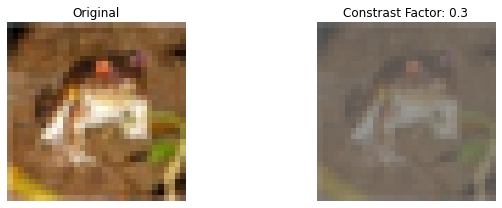

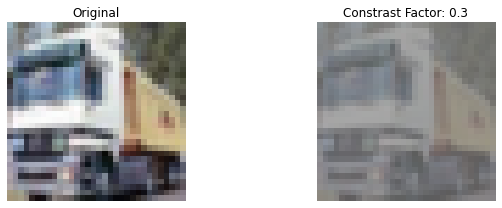

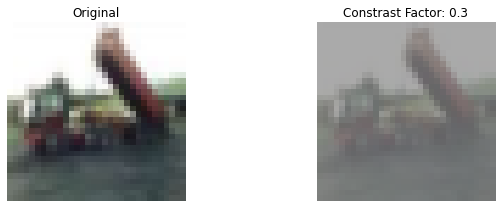

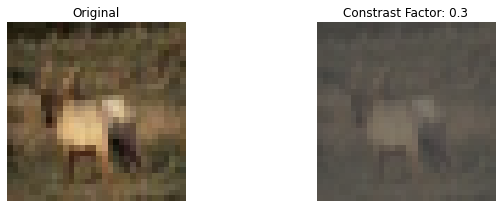

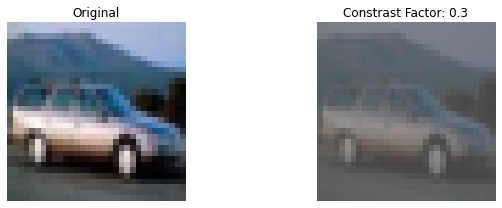

In [4]:
i=0
for constrasted_image in train_contrasted_images:
    fig = plt.figure(figsize=(10, 3))
    ax1,ax2 = fig.subplots(1,2)
    ax1.imshow(train_dataset.data[i], cmap='gray')
    ax1.set_axis_off()
    ax1.set_title("Original")
    ax2.imshow(constrasted_image, cmap='gray')
    ax2.set_axis_off()
    ax2.set_title("Constrast Factor: "+str(contrast_factor))
    fig.set_tight_layout(True)
    plt.show()
    i +=1
    
    if i==5:
        break
    

# Combining original and contrasted images

In [5]:
original_image_labels = np.zeros(len(train_dataset.data))
contrasted_image_labels = np.ones(len(train_contrasted_images))

test_original_image_labels = np.zeros(len(test_dataset.data))
test_contrasted_image_labels = np.ones(len(test_contrasted_images))

train_original_and_contrasted_images = np.concatenate((train_dataset.data, train_contrasted_images), axis=0)
train_contrast_labels = np.concatenate((original_image_labels, contrasted_image_labels), axis=None)
train_image_labels = np.concatenate((train_dataset.targets, train_dataset.targets), axis=None)

test_original_and_contrasted_images = np.concatenate((test_dataset.data, test_contrasted_images), axis=0)
test_contrast_labels = np.concatenate((test_original_image_labels, test_contrasted_image_labels), axis=None)


print("Combined contrasted and original train images shape")
print(train_original_and_contrasted_images.shape)


Combined contrasted and original train images shape
(100000, 32, 32, 3)


# Extract image features

In [6]:
from image_feature_extractor import Img2Vec

img2vec = Img2Vec()

Z = img2vec.get_vec(train_original_and_contrasted_images)

Z_test = img2vec.get_vec(test_original_and_contrasted_images)

Z_test_original = img2vec.get_vec(test_dataset.data)

Z_test_contrasted = img2vec.get_vec(test_contrasted_images)

# vec.shape
print("Shape of extracted features for combined contrasted and original images")
print(Z.shape)

print("Shape of extracted features for original test images")
print(Z_test_original.shape)

print("Shape of extracted features for contrasted test images")
print(Z_test_contrasted.shape)


Shape of extracted features for combined contrasted and original images
(100000, 512)
Shape of extracted features for original test images
(10000, 512)
Shape of extracted features for contrasted test images
(10000, 512)


# Obtaining contrast prediction coefficients

In [7]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression(random_state=0).fit(Z, train_contrast_labels)

contrast_coefficients = lr_model.coef_.reshape(-1,1)
contrast_coefficients = contrast_coefficients / np.linalg.norm(contrast_coefficients)

print("Contrast coefficients shape")
print(contrast_coefficients.shape)

print('Contrast prediction accuracy on training data: ', lr_model.score(Z, train_contrast_labels))

print('Contrast prediction accuracy on test data-rotaed and original combined: ', lr_model.score(Z_test, test_contrast_labels))

    


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Contrast coefficients shape
(512, 1)
Contrast prediction accuracy on training data:  0.99631
Contrast prediction accuracy on test data-rotaed and original combined:  0.9939


# Prediction Accuracies on extracted image features Z ( features obtained from the feature extractor)

In [8]:
# Trained on original extracted image features Z, tested on contrasted extracted image features Z
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


targets_train = np.array(test_dataset.targets)
targets_test = np.array(test_dataset.targets)


logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(Z_test_original, targets_train)

print('LR Accuracy within training data - Z original features: ',logistic_regression_model.score(Z_test_original, targets_train))
print('LR Accuracy on test data - Z contrasted features: ', logistic_regression_model.score(Z_test_contrasted, targets_test))



LR Accuracy within training data - Z original features:  0.7486
LR Accuracy on test data - Z contrasted features:  0.3866


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Find L, get F features, plot histograms and perform predictions





Results for lamda  100000

Printing eigenvalues
(512,)
[1.05059068e-10 1.02769923e+02 5.36000711e+02 6.42173781e+02
 6.96202254e+02 1.05245611e+03 1.09099442e+03 1.13719801e+03
 1.16344624e+03 1.19302357e+03 1.24189798e+03 1.32302823e+03
 1.43521630e+03 1.45746140e+03 1.50029549e+03 1.51332360e+03
 1.54366341e+03 1.57236110e+03 1.60349436e+03 1.64485282e+03
 1.67392995e+03 1.72081534e+03 1.72986251e+03 1.78357723e+03
 1.82007652e+03 1.84097403e+03 1.88874566e+03 1.90854169e+03
 1.92823091e+03 1.95655202e+03 1.98918556e+03 2.00832846e+03
 2.02732229e+03 2.04088876e+03 2.07223765e+03 2.07985470e+03
 2.10448682e+03 2.12309144e+03 2.12715559e+03 2.14091430e+03
 2.16682741e+03 2.18773073e+03 2.22493374e+03 2.23323911e+03
 2.26106737e+03 2.28021814e+03 2.30009806e+03 2.33383632e+03
 2.35988011e+03 2.37035471e+03 2.38928153e+03 2.40328965e+03
 2.42240558e+03 2.44744321e+03 2.46914781e+03 2.50270294e+03
 2.52589097e+03 2.53389155e+03 2.55766282e+03 2.57077741e+03
 2.58483890e+03 2.59066936

(512, 512)

array([[ 5.03668562e-02, -6.41125179e-04,  2.52844553e-03, ...,
        -4.54232772e-03,  1.05183476e-02,  3.30985792e-02],
       [-4.32631817e-02,  1.43508250e-03,  1.04929206e-03, ...,
         1.64014031e-01,  7.86132195e-02,  6.17166315e-02],
       [ 3.40565116e-02, -1.71668182e-03, -4.72477450e-03, ...,
         3.44161160e-02,  2.02425592e-02,  2.46250928e-02],
       ...,
       [ 1.85172463e-02,  1.96161213e-04, -4.55721918e-04, ...,
         1.44801685e-02,  3.59496189e-02,  1.08854742e-01],
       [-1.03639633e-01, -4.56818175e-04, -4.18136581e-04, ...,
         1.97237464e-02,  2.13295127e-02,  2.53532254e-02],
       [-2.05639415e-02,  1.68478106e-02,  2.26276363e-05, ...,
        -1.24885375e-02,  4.02379734e-03,  1.25323830e-02]])

Printing least k eigenvalues before removing the zero eigenvalue
[   0.          102.7699233   536.00071138  642.17378096  696.20225418
 1052.45611337 1090.99441886 1137.19801417 1163.44624399 1193.02357419
 1241.89798004 1323.02823056 1435.21629942 1457.4614031  1500.29549026
 1513.32360339 1543.66341429 1572.36109974 1603.4943587  1644.85281699
 1673.92994631 1720.81533533 1729.86251187 1783.57723404 1820.07652282]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[ 102.7699233   536.00071138  642.17378096  696.20225418 1052.45611337
 1090.99441886 1137.19801417 1163.44624399 1193.02357419 1241.89798004
 1323.02823056 1435.21629942 1457.4614031  1500.29549026 1513.32360339
 1543.66341429 1572.36109974 1603.4943587  1644.85281699 1673.92994631
 1720.81533533 1729.86251187 1783.57723404 1820.07652282]
Printing non zero indeces of the least k-1 eigenvalues
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.021970,0.018143,0.072643,0.071699,0.010859,0.023564,0.044059,0.131678,0.049527,0.065724,...,0.158938,0.034352,0.011510,0.002438,0.094494,0.031884,0.045663,0.003843,0.144654,0.078428
1,3.200015,0.035369,0.003667,0.041672,0.038807,0.009367,0.022501,0.011403,0.025644,0.060533,...,0.086607,0.144250,0.097073,0.003468,0.141837,0.036036,0.293186,0.204276,0.194050,0.090168
2,3.194737,0.007453,0.002109,0.023917,0.023052,0.017608,0.048680,0.056524,0.043922,0.048861,...,0.026315,0.015869,0.097837,0.130086,0.028786,0.069654,0.059068,0.168303,0.080209,0.059033
3,1.697847,0.007152,0.044357,0.008190,0.021641,0.053596,0.061523,0.031322,0.102258,0.011838,...,0.099005,0.019664,0.065433,0.000596,0.282573,0.287298,0.095636,0.013594,0.050562,0.074128
4,1.591675,0.001154,0.021914,0.047247,0.006570,0.145619,0.149581,0.057937,0.041318,0.016280,...,0.091953,0.273661,0.069976,0.088019,0.050777,0.069341,0.046372,0.116054,0.254211,0.026426


Histogram for F Test feature  0


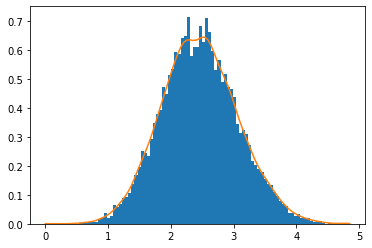

Histogram for F Test feature  1


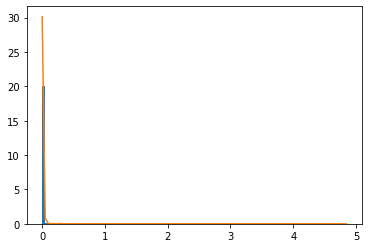

Histogram for F Test feature  2


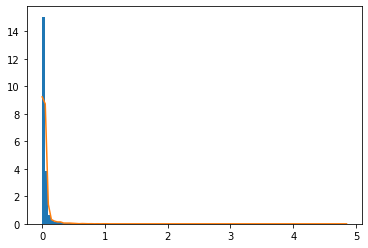

Histogram for F Test feature  3


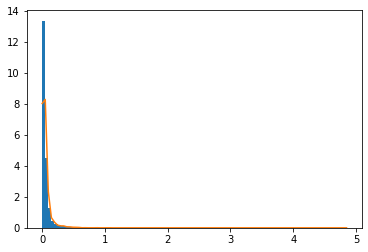

Histogram for F Test feature  4


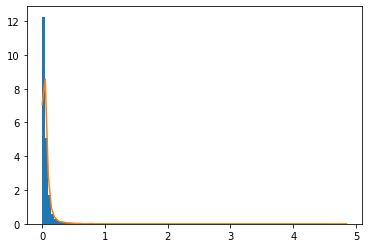

Histogram for F Test feature  5


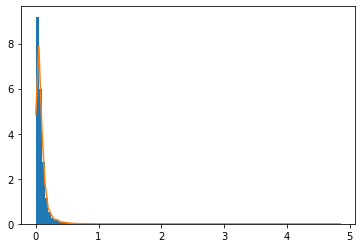

Histogram for F Test feature  6


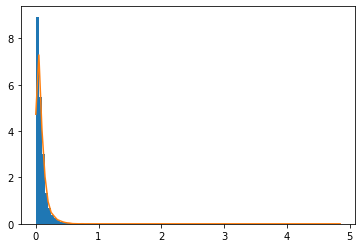

Histogram for F Test feature  7


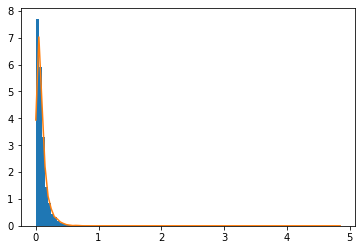

Histogram for F Test feature  8


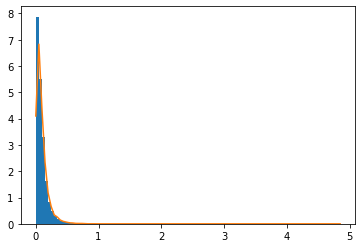

Histogram for F Test feature  9


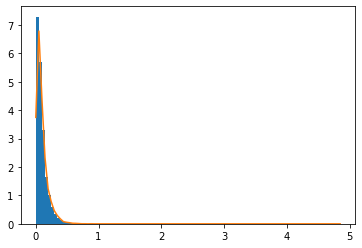

Histogram for F Test feature  10


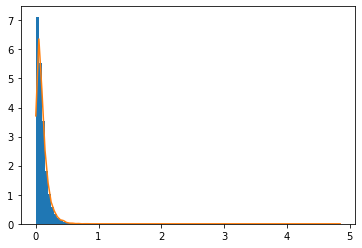

Histogram for F Test feature  11


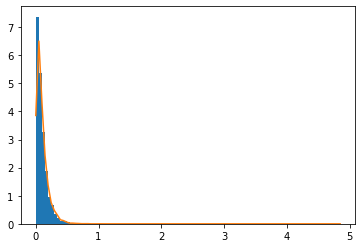

Histogram for F Test feature  12


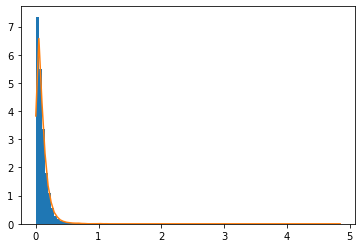

Histogram for F Test feature  13


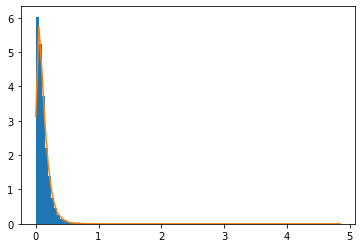

Histogram for F Test feature  14


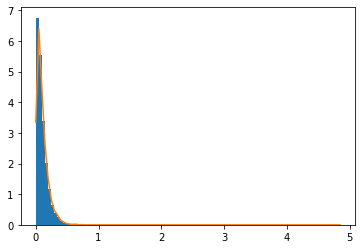

Histogram for F Test feature  15


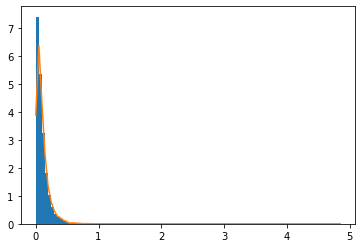

Histogram for F Test feature  16


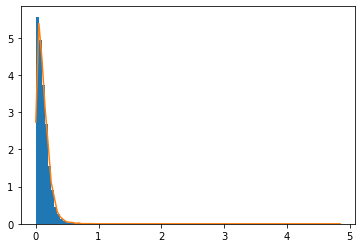

Histogram for F Test feature  17


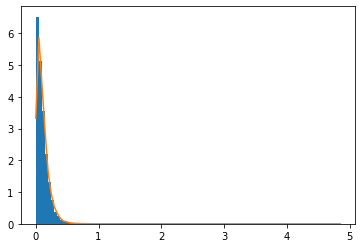

Histogram for F Test feature  18


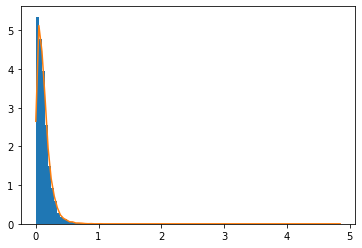

Histogram for F Test feature  19


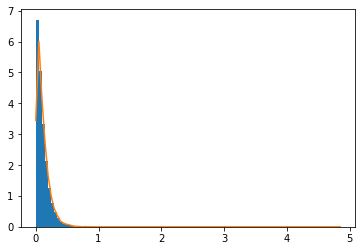

Histogram for F Test feature  20


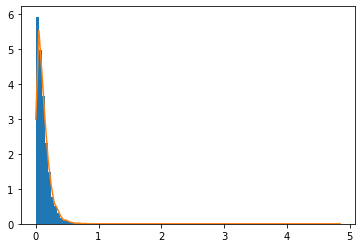

Histogram for F Test feature  21


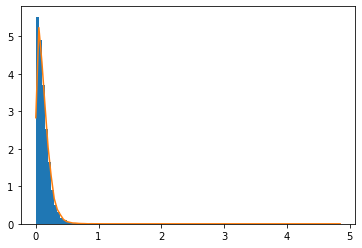

Histogram for F Test feature  22


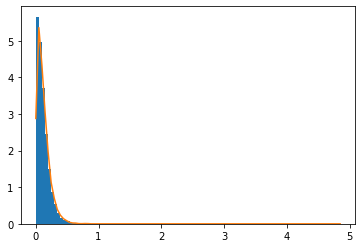

Histogram for F Test feature  23


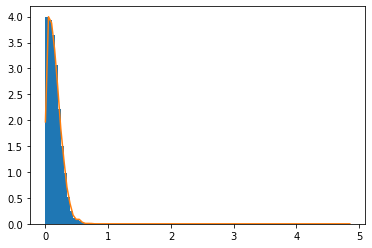

Histogram for F Test feature  24


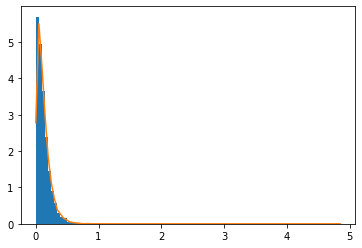

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.2459
LR Accuracy on test data - All features:  0.136
Accuracy for without feature  0
Logistic Regression Accuracy within training data - not contrasted:  0.2369
Logistic Regression Accuracy on test data - contrasted:  0.1622
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2425
Logistic Regression Accuracy on test data - contrasted:  0.1355
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2441
Logistic Regression Accuracy on test data - contrasted:  0.1354
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2462
Logistic Regression Accuracy on test data - contrasted:  0.1358
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2452
Logistic Regression Accuracy on test data - contrasted:  0.135
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2439
Logistic Regression Accuracy on test data - contrasted:  0.1384
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2422
Logistic Regression Accuracy on test data - contrasted:  0.1356
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2407
Logistic Regression Accuracy on test data - contrasted:  0.1369
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2357
Logistic Regression Accuracy on test data - contrasted:  0.1327
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2393
Logistic Regression Accuracy on test data - contrasted:  0.1381
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2412
Logistic Regression Accuracy on test data - contrasted:  0.1367
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2441
Logistic Regression Accuracy on test data - contrasted:  0.136
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.243
Logistic Regression Accuracy on test data - contrasted:  0.1358
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2396
Logistic Regression Accuracy on test data - contrasted:  0.1347
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2408
Logistic Regression Accuracy on test data - contrasted:  0.1338
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2424
Logistic Regression Accuracy on test data - contrasted:  0.1368
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2427
Logistic Regression Accuracy on test data - contrasted:  0.1335
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2413
Logistic Regression Accuracy on test data - contrasted:  0.1367
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2407
Logistic Regression Accuracy on test data - contrasted:  0.1345
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2413
Logistic Regression Accuracy on test data - contrasted:  0.1279
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2445
Logistic Regression Accuracy on test data - contrasted:  0.1324
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2392
Logistic Regression Accuracy on test data - contrasted:  0.1356
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.2426
Logistic Regression Accuracy on test data - contrasted:  0.1343
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.24
Logistic Regression Accuracy on test data - contrasted:  0.1373
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.241
Logistic Regression Accuracy on test data - contrasted:  0.1419




Results for lamda  10

Printing eigenvalues
(512,)
[-1.71537508e+01 -6.86751475e+00 -3.79481247e+00 -2.06223525e+00
 -1.25195062e+00 -9.67314758e-01 -6.72486129e-01 -4.93376821e-01
 -2.70268918e-01 -1.23715091e-01 -3.11397280e-02 -1.34912639e-02
 -1.59171964e-08  9.81357514e-03  3.39970881e-02  4.70490262e-02
  5.68856212e-02  6.49879560e-02  7.09833386e-02  9.42729747e-02
  9.75727114e-02  9.86121484e-02  1.02455477e-01  1.04905247e-01
  1.06228651e-01  1.15778716e-01  1.16612290e-01  1.27723823e-01
  1.30912908e-01  1.32619459e-01  1.37994609e-01  1.38587839e-01
  1.40259965e-01  1.44444835e-01  1.46532400e-01  1.47288875e-01
  1.50808708e-01  1.55304683e-01  1.56777103e-01  1.60936653e-01
  1.65603692e-01  1.66982966e-01  1.68730972e-01  1.70625932e-01
  1.72804717e-01  1.74555149e-01  1.76310788e-01  1.79410570e-01
  1.81046741e-01  1.822276

(512, 512)

array([[ 0.02352554,  0.00590326, -0.01704888, ..., -0.00296228,
         0.01073742,  0.03222864],
       [-0.00030737,  0.05912283,  0.10282429, ...,  0.15720795,
         0.06861949,  0.06010652],
       [-0.01505348,  0.02416324,  0.00727166, ...,  0.03237763,
         0.01751009,  0.024493  ],
       ...,
       [ 0.07303601, -0.14277637, -0.03413231, ...,  0.01374384,
         0.03604427,  0.11189599],
       [ 0.04246947, -0.03330289,  0.06702557, ...,  0.01396857,
         0.01932149,  0.02352684],
       [-0.00131071, -0.01618659,  0.00597991, ..., -0.01219568,
         0.00378032,  0.01320478]])

Printing least k eigenvalues before removing the zero eigenvalue
[-1.71537508e+01 -6.86751475e+00 -3.79481247e+00 -2.06223525e+00
 -1.25195062e+00 -9.67314758e-01 -6.72486129e-01 -4.93376821e-01
 -2.70268918e-01 -1.23715091e-01 -3.11397280e-02 -1.34912639e-02
  0.00000000e+00  9.81357514e-03  3.39970881e-02  4.70490262e-02
  5.68856212e-02  6.49879560e-02  7.09833386e-02  9.42729747e-02
  9.75727114e-02  9.86121484e-02  1.02455477e-01  1.04905247e-01
  1.06228651e-01]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-1.71537508e+01 -6.86751475e+00 -3.79481247e+00 -2.06223525e+00
 -1.25195062e+00 -9.67314758e-01 -6.72486129e-01 -4.93376821e-01
 -2.70268918e-01 -1.23715091e-01 -3.11397280e-02 -1.34912639e-02
  9.81357514e-03  3.39970881e-02  4.70490262e-02  5.68856212e-02
  6.49879560e-02  7.09833386e-02  9.42729747e-02  9.75727114e-02
  9.86121484e-02  1.02455477e-01  1.04905247e-01  1.06228651e-01]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.021977,5.898528,7.305259,0.856361,0.030982,0.222429,1.462793,2.789165,0.080638,2.271797,...,0.040147,0.041191,0.151553,0.125423,0.229806,0.269116,0.313401,0.233715,0.297576,0.483207
1,3.200015,5.596352,7.093625,0.170426,0.925632,2.723973,0.481864,1.462515,1.098701,1.754391,...,0.014163,0.094356,0.037794,0.130134,0.572280,0.087425,0.025121,0.161564,0.152441,0.231012
2,3.194731,3.933674,6.998993,1.591995,0.459836,0.868184,1.167574,0.404010,1.729205,0.857031,...,0.075286,0.075298,0.141236,0.456406,0.259967,0.008920,0.005784,0.004336,0.055329,0.022633
3,1.697844,1.243282,3.845387,0.715376,1.276663,1.822857,0.036087,1.046257,0.960205,1.265750,...,0.031994,0.018354,0.060924,0.076013,0.335455,0.131145,0.127202,0.066072,0.290416,0.321353
4,1.591671,3.156290,6.091927,1.384743,0.995208,2.267274,0.611373,0.118003,1.243968,1.379613,...,0.134744,0.477641,0.067661,0.635392,0.271798,0.038514,0.096983,0.222028,0.223626,0.156143


Histogram for F Test feature  0


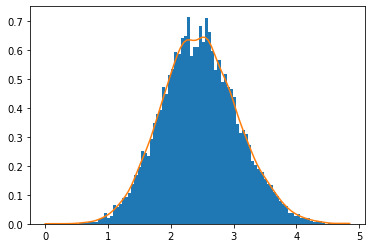

Histogram for F Test feature  1


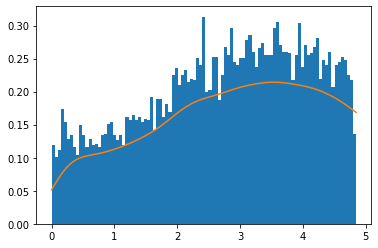

Histogram for F Test feature  2


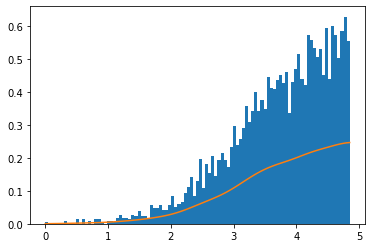

Histogram for F Test feature  3


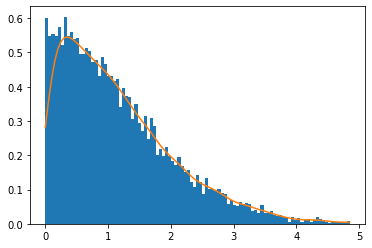

Histogram for F Test feature  4


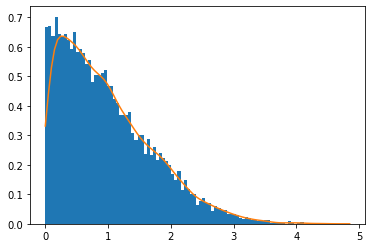

Histogram for F Test feature  5


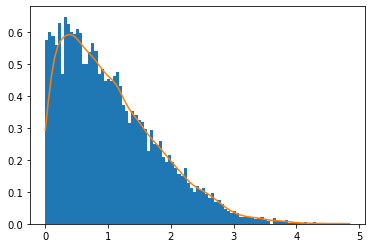

Histogram for F Test feature  6


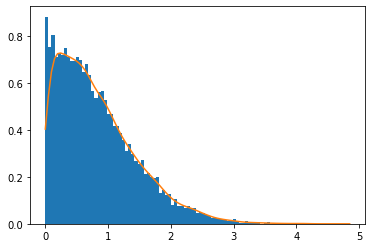

Histogram for F Test feature  7


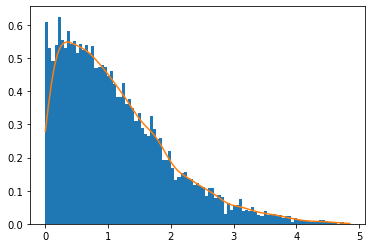

Histogram for F Test feature  8


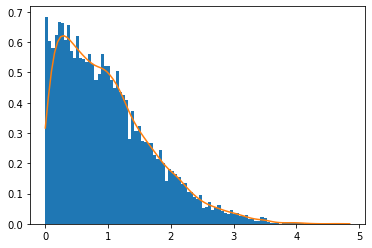

Histogram for F Test feature  9


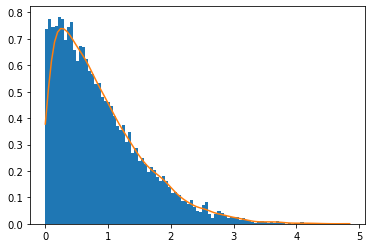

Histogram for F Test feature  10


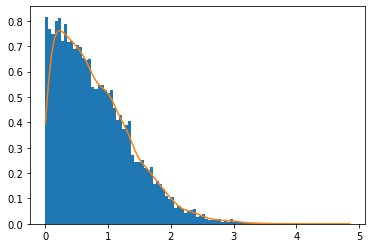

Histogram for F Test feature  11


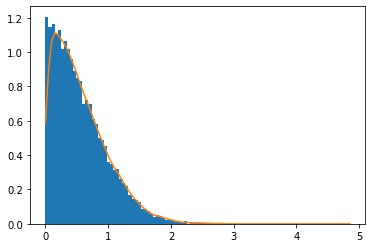

Histogram for F Test feature  12


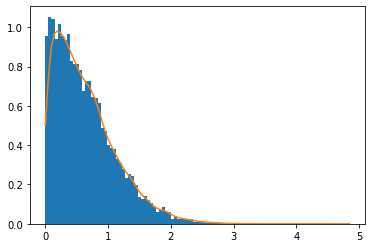

Histogram for F Test feature  13


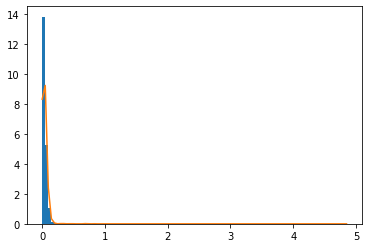

Histogram for F Test feature  14


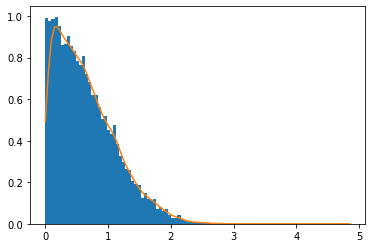

Histogram for F Test feature  15


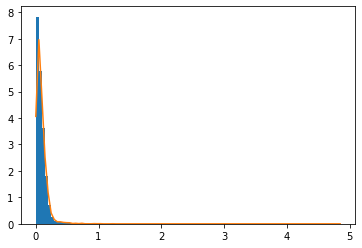

Histogram for F Test feature  16


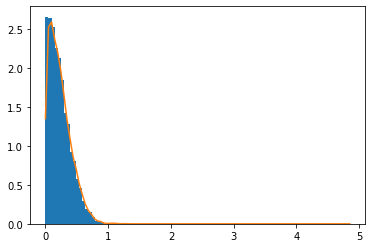

Histogram for F Test feature  17


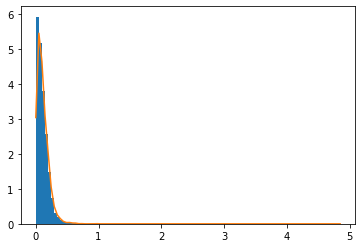

Histogram for F Test feature  18


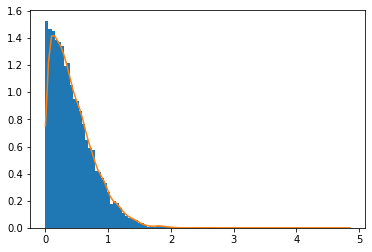

Histogram for F Test feature  19


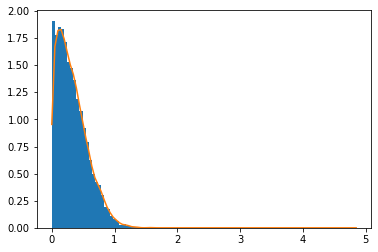

Histogram for F Test feature  20


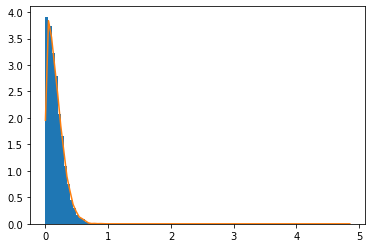

Histogram for F Test feature  21


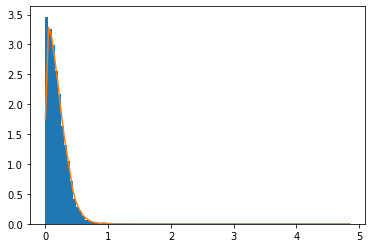

Histogram for F Test feature  22


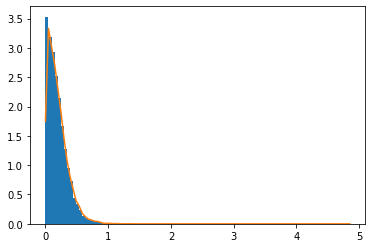

Histogram for F Test feature  23


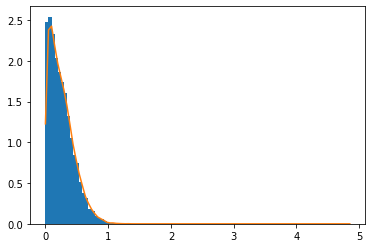

Histogram for F Test feature  24


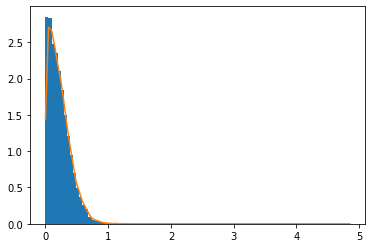

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.5244
LR Accuracy on test data - All features:  0.2927
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5222
Logistic Regression Accuracy on test data - contrasted:  0.3064
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5197
Logistic Regression Accuracy on test data - contrasted:  0.285
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5156
Logistic Regression Accuracy on test data - contrasted:  0.3077
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.4794
Logistic Regression Accuracy on test data - contrasted:  0.2316
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5104
Logistic Regression Accuracy on test data - contrasted:  0.2852
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.516
Logistic Regression Accuracy on test data - contrasted:  0.2745
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5082
Logistic Regression Accuracy on test data - contrasted:  0.2841
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5184
Logistic Regression Accuracy on test data - contrasted:  0.2809
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.4989
Logistic Regression Accuracy on test data - contrasted:  0.2718
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5167
Logistic Regression Accuracy on test data - contrasted:  0.2905
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5148
Logistic Regression Accuracy on test data - contrasted:  0.2786
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5155
Logistic Regression Accuracy on test data - contrasted:  0.2875
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5181
Logistic Regression Accuracy on test data - contrasted:  0.28
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5243
Logistic Regression Accuracy on test data - contrasted:  0.2928
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5214
Logistic Regression Accuracy on test data - contrasted:  0.292
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5228
Logistic Regression Accuracy on test data - contrasted:  0.2906
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5224
Logistic Regression Accuracy on test data - contrasted:  0.2918
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5242
Logistic Regression Accuracy on test data - contrasted:  0.2911
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5196
Logistic Regression Accuracy on test data - contrasted:  0.2905
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5189
Logistic Regression Accuracy on test data - contrasted:  0.2909
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5227
Logistic Regression Accuracy on test data - contrasted:  0.2922
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5218
Logistic Regression Accuracy on test data - contrasted:  0.2911
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5197
Logistic Regression Accuracy on test data - contrasted:  0.2932
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5188
Logistic Regression Accuracy on test data - contrasted:  0.2895
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5213
Logistic Regression Accuracy on test data - contrasted:  0.2944




Results for lamda  1

Printing eigenvalues
(512,)
[-6.36681398e+01 -1.53570470e+01 -1.43274679e+01 -7.97922523e+00
 -6.21715202e+00 -5.55154496e+00 -5.12707925e+00 -4.42268621e+00
 -4.11253431e+00 -3.15400898e+00 -2.76267350e+00 -2.53887261e+00
 -2.26277194e+00 -2.11192506e+00 -1.96987865e+00 -1.79943002e+00
 -1.62941063e+00 -1.45224687e+00 -1.37810034e+00 -1.23736619e+00
 -1.12356084e+00 -1.05843906e+00 -1.03090290e+00 -9.72622591e-01
 -8.58492152e-01 -8.35367699e-01 -8.04900384e-01 -6.81320789e-01
 -6.57308681e-01 -6.28375774e-01 -6.22412335e-01 -5.82114079e-01
 -5.41029128e-01 -5.03999391e-01 -4.80678650e-01 -4.59435819e-01
 -4.46383711e-01 -4.20869276e-01 -4.05639289e-01 -3.82324823e-01
 -3.76831261e-01 -3.52125317e-01 -3.49291926e-01 -3.22656503e-01
 -2.97320263e-01 -2.80018907e-01 -2.73100373e-01 -2.68977125e-01
 -2.64660058e-01 -2.537833

(512, 512)

array([[-0.03401662, -0.00156685,  0.00285736, ...,  0.01995224,
        -0.0109566 , -0.0100487 ],
       [-0.05857318, -0.05229081, -0.1465557 , ...,  0.05984758,
        -0.02010243, -0.01625299],
       [-0.01559159, -0.00771963, -0.04050005, ...,  0.00716445,
        -0.00221662, -0.0132035 ],
       ...,
       [-0.05444446, -0.11697071,  0.09641355, ..., -0.00221482,
        -0.06205519, -0.15250479],
       [-0.04962961, -0.07325242, -0.02637995, ..., -0.00511518,
        -0.01725581, -0.00190061],
       [ 0.00139003,  0.00198031, -0.00031013, ..., -0.01302435,
         0.00047224, -0.01756688]])

Printing least k eigenvalues before removing the zero eigenvalue
[-63.66813982 -15.35704703 -14.32746788  -7.97922523  -6.21715202
  -5.55154496  -5.12707925  -4.42268621  -4.11253431  -3.15400898
  -2.7626735   -2.53887261  -2.26277194  -2.11192506  -1.96987865
  -1.79943002  -1.62941063  -1.45224687  -1.37810034  -1.23736619
  -1.12356084  -1.05843906  -1.0309029   -0.97262259  -0.85849215]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-63.66813982 -15.35704703 -14.32746788  -7.97922523  -6.21715202
  -5.55154496  -5.12707925  -4.42268621  -4.11253431  -3.15400898
  -2.7626735   -2.53887261  -2.26277194  -2.11192506  -1.96987865
  -1.79943002  -1.62941063  -1.45224687  -1.37810034  -1.23736619
  -1.12356084  -1.05843906  -1.0309029   -0.97262259]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.021970,0.332889,6.342548,8.744972,0.850563,2.207232,3.126926,0.711760,2.225434,1.876899,...,1.404237,0.517177,1.216244,0.201583,0.732503,0.019869,0.136508,2.396580,1.561760,0.075830
1,3.200015,0.051161,3.974558,9.302931,0.249761,5.442155,1.253758,3.333908,1.322292,1.063188,...,2.046908,3.342998,1.200281,0.425174,0.871649,2.267687,1.854389,2.280190,1.087782,1.027645
2,3.194737,1.853600,2.758868,8.335392,1.431437,2.455910,2.243315,1.367524,1.811092,1.703053,...,1.192207,0.659460,0.620460,0.238364,0.917001,0.706443,1.254787,0.753169,0.102126,0.606318
3,1.697847,1.558607,1.126395,5.413456,2.047733,3.001377,0.534178,0.692186,0.178158,0.797396,...,1.957394,1.634327,1.090166,0.782279,0.287939,0.334092,0.950107,0.841409,0.447795,1.650953
4,1.591675,0.509928,8.174517,3.103161,1.951841,3.873729,0.753878,0.303710,2.292575,1.303133,...,0.146402,0.023018,1.456695,0.723834,0.543313,2.019348,1.360471,0.256575,2.307544,0.975896


Histogram for F Test feature  0


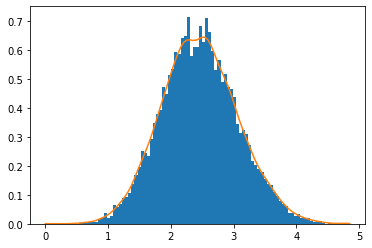

Histogram for F Test feature  1


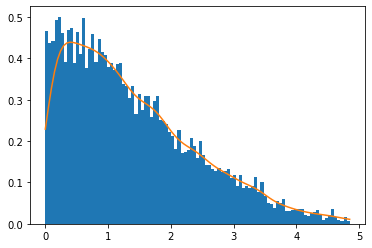

Histogram for F Test feature  2


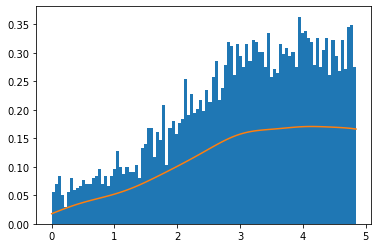

Histogram for F Test feature  3


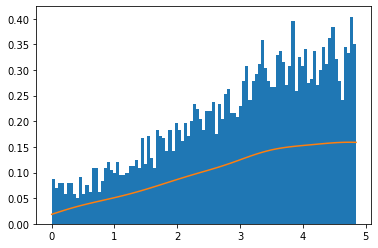

Histogram for F Test feature  4


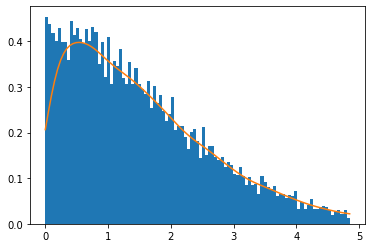

Histogram for F Test feature  5


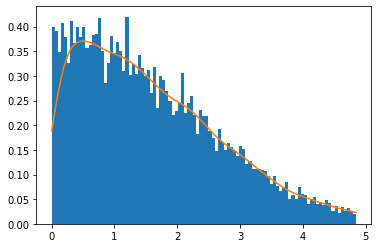

Histogram for F Test feature  6


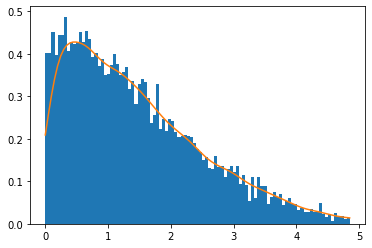

Histogram for F Test feature  7


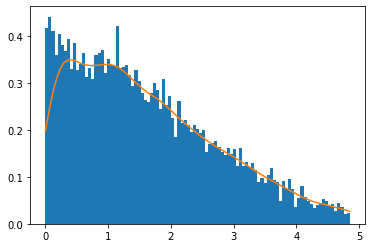

Histogram for F Test feature  8


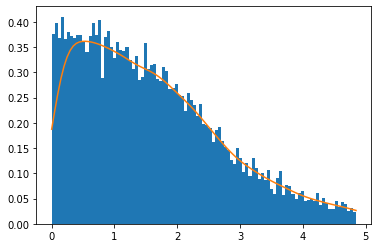

Histogram for F Test feature  9


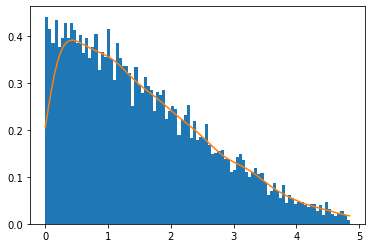

Histogram for F Test feature  10


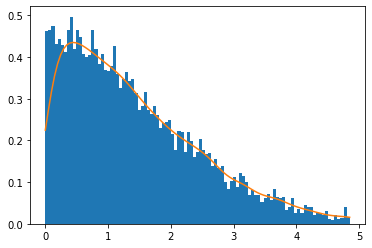

Histogram for F Test feature  11


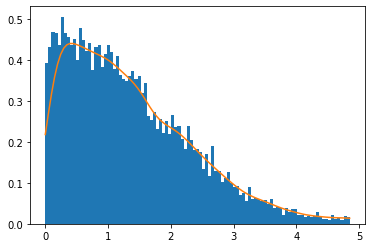

Histogram for F Test feature  12


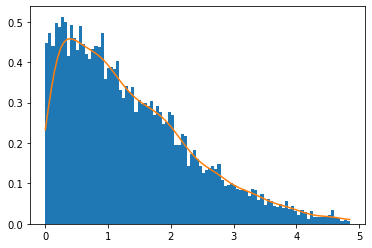

Histogram for F Test feature  13


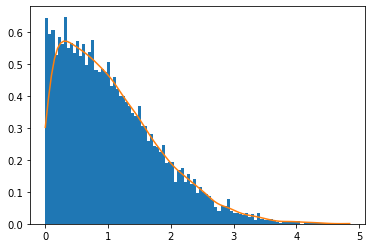

Histogram for F Test feature  14


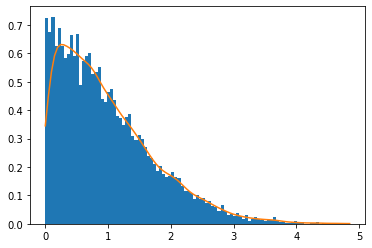

Histogram for F Test feature  15


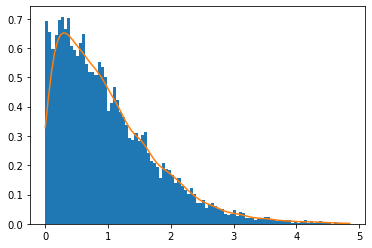

Histogram for F Test feature  16


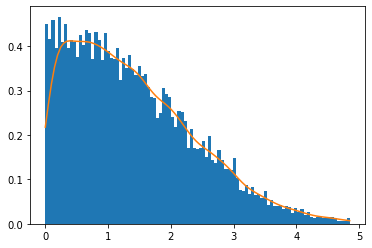

Histogram for F Test feature  17


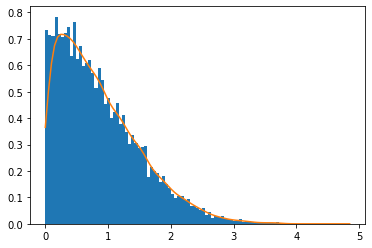

Histogram for F Test feature  18


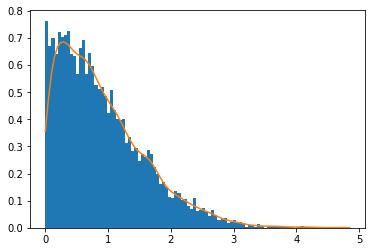

Histogram for F Test feature  19


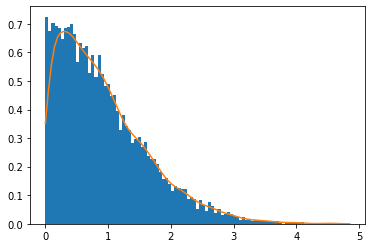

Histogram for F Test feature  20


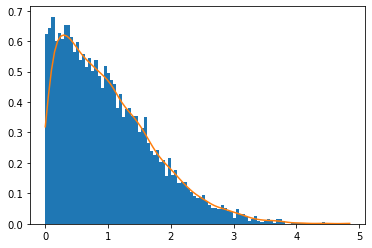

Histogram for F Test feature  21


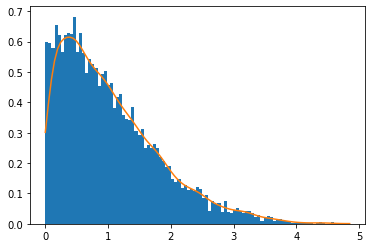

Histogram for F Test feature  22


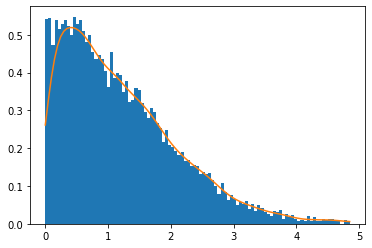

Histogram for F Test feature  23


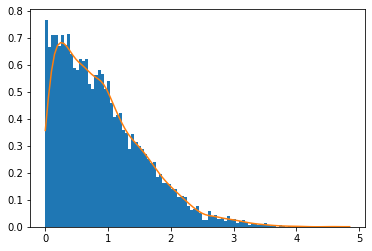

Histogram for F Test feature  24


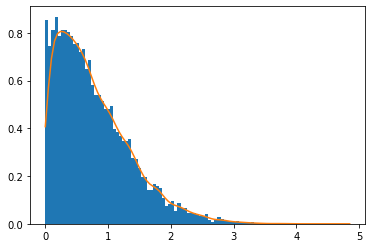

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.555
LR Accuracy on test data - All features:  0.2745
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5569
Logistic Regression Accuracy on test data - contrasted:  0.2944
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5547
Logistic Regression Accuracy on test data - contrasted:  0.2708
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5413
Logistic Regression Accuracy on test data - contrasted:  0.2612
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5421
Logistic Regression Accuracy on test data - contrasted:  0.2912
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5373
Logistic Regression Accuracy on test data - contrasted:  0.2533
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5412
Logistic Regression Accuracy on test data - contrasted:  0.2472
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5434
Logistic Regression Accuracy on test data - contrasted:  0.2585
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5493
Logistic Regression Accuracy on test data - contrasted:  0.2743
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5457
Logistic Regression Accuracy on test data - contrasted:  0.2714
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5428
Logistic Regression Accuracy on test data - contrasted:  0.2664
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5501
Logistic Regression Accuracy on test data - contrasted:  0.2768
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.541
Logistic Regression Accuracy on test data - contrasted:  0.2592
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5449
Logistic Regression Accuracy on test data - contrasted:  0.2737
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5512
Logistic Regression Accuracy on test data - contrasted:  0.2787
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5495
Logistic Regression Accuracy on test data - contrasted:  0.2689
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5436
Logistic Regression Accuracy on test data - contrasted:  0.2718
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.551
Logistic Regression Accuracy on test data - contrasted:  0.2721
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5552
Logistic Regression Accuracy on test data - contrasted:  0.2732
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5492
Logistic Regression Accuracy on test data - contrasted:  0.2731
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5519
Logistic Regression Accuracy on test data - contrasted:  0.269
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5543
Logistic Regression Accuracy on test data - contrasted:  0.2762
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5501
Logistic Regression Accuracy on test data - contrasted:  0.2752
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5515
Logistic Regression Accuracy on test data - contrasted:  0.2868
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5558
Logistic Regression Accuracy on test data - contrasted:  0.2729
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5529
Logistic Regression Accuracy on test data - contrasted:  0.2706




Results for lamda  0.1

Printing eigenvalues
(512,)
[-1.24475972e+02 -2.13570795e+01 -1.91359852e+01 -1.29814366e+01
 -9.14897713e+00 -8.22493669e+00 -7.40097828e+00 -6.66960724e+00
 -5.56619204e+00 -5.14158204e+00 -4.64479892e+00 -4.13759906e+00
 -3.45517900e+00 -3.03083869e+00 -2.91561063e+00 -2.86510031e+00
 -2.29768229e+00 -2.22652295e+00 -2.06592619e+00 -1.91055675e+00
 -1.82184914e+00 -1.79025258e+00 -1.71679041e+00 -1.54945128e+00
 -1.48644781e+00 -1.43568366e+00 -1.28951765e+00 -1.25673613e+00
 -1.25428653e+00 -1.16998569e+00 -1.10830919e+00 -1.05798502e+00
 -9.92236099e-01 -9.42235701e-01 -9.34733032e-01 -9.16884654e-01
 -8.39098027e-01 -8.21080314e-01 -8.11383337e-01 -7.73243151e-01
 -7.49631221e-01 -7.09385012e-01 -6.83671802e-01 -6.65594702e-01
 -6.30170861e-01 -6.22695139e-01 -5.84859646e-01 -5.58104503e-01
 -5.54109244e-01 -5.3073

(512, 512)

array([[ 0.03673269, -0.00465997,  0.00121477, ...,  0.04743876,
        -0.02963571, -0.00511514],
       [ 0.06727825, -0.1300111 ,  0.08568998, ..., -0.04590363,
        -0.01210167, -0.02235194],
       [ 0.02266623, -0.03084828,  0.0289278 , ..., -0.0239518 ,
         0.00457597, -0.00147727],
       ...,
       [ 0.081406  , -0.04912746, -0.09758574, ...,  0.07075978,
        -0.06328835,  0.19383108],
       [ 0.03940504, -0.06834582, -0.03368861, ..., -0.01105829,
        -0.03491104,  0.01358817],
       [ 0.00592917,  0.00251366,  0.01028619, ..., -0.00467965,
         0.00779238,  0.00338855]])

Printing least k eigenvalues before removing the zero eigenvalue
[-124.47597184  -21.35707947  -19.13598522  -12.98143655   -9.14897713
   -8.22493669   -7.40097828   -6.66960724   -5.56619204   -5.14158204
   -4.64479892   -4.13759906   -3.455179     -3.03083869   -2.91561063
   -2.86510031   -2.29768229   -2.22652295   -2.06592619   -1.91055675
   -1.82184914   -1.79025258   -1.71679041   -1.54945128   -1.48644781]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-124.47597184  -21.35707947  -19.13598522  -12.98143655   -9.14897713
   -8.22493669   -7.40097828   -6.66960724   -5.56619204   -5.14158204
   -4.64479892   -4.13759906   -3.455179     -3.03083869   -2.91561063
   -2.86510031   -2.29768229   -2.22652295   -2.06592619   -1.91055675
   -1.82184914   -1.79025258   -1.71679041   -1.54945128]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.021970,3.062010,0.603492,12.053014,0.859452,1.943911,0.198890,0.707215,3.982556,1.974795,...,1.369194,0.913756,0.881873,0.202027,1.366445,2.669103,2.089973,2.194245,2.501917,0.236133
1,3.200015,3.155230,2.896062,11.436821,1.032488,4.464143,3.836783,1.117817,1.102607,0.901697,...,1.738341,0.361341,3.258228,0.571883,0.261814,2.342923,0.679040,1.384089,1.426154,0.279473
2,3.194737,3.583742,2.237141,7.721917,1.968909,2.481546,3.109650,3.397100,1.440149,1.865256,...,0.365054,1.967685,0.185681,0.309651,1.350713,0.021566,2.092183,0.793470,1.367200,0.088991
3,1.697847,2.371693,2.277911,5.058029,2.585993,2.913602,0.707383,0.226023,0.442528,0.446807,...,0.219248,1.439165,0.399094,0.833643,1.277243,0.511692,0.698256,0.086222,0.120522,1.761726
4,1.591675,1.525934,6.876368,5.320545,4.583596,3.574955,1.303539,0.443980,0.918210,1.719151,...,1.212329,0.704227,0.417054,1.269110,1.337570,2.238536,2.308101,0.538012,0.229180,0.687296


Histogram for F Test feature  0


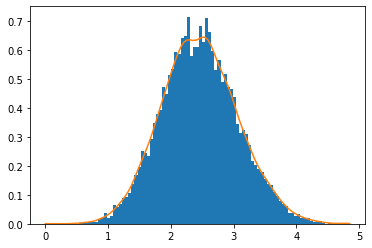

Histogram for F Test feature  1


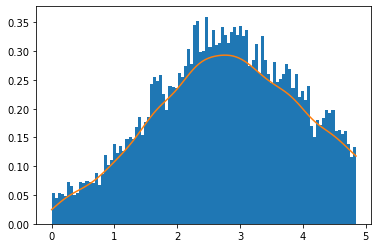

Histogram for F Test feature  2


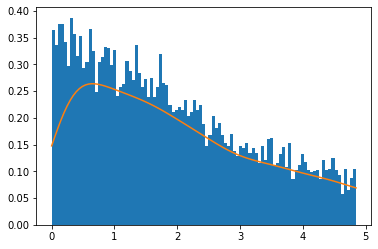

Histogram for F Test feature  3


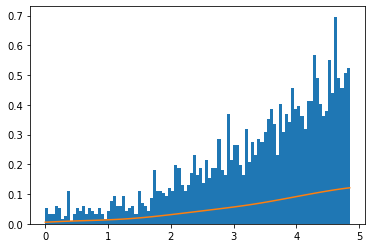

Histogram for F Test feature  4


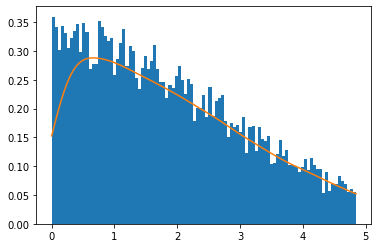

Histogram for F Test feature  5


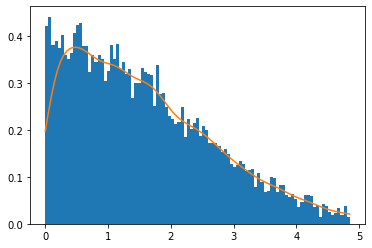

Histogram for F Test feature  6


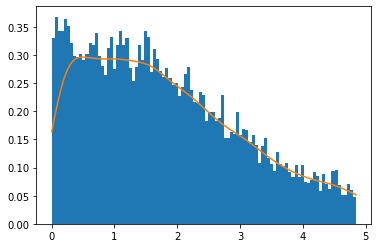

Histogram for F Test feature  7


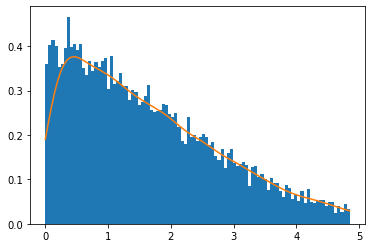

Histogram for F Test feature  8


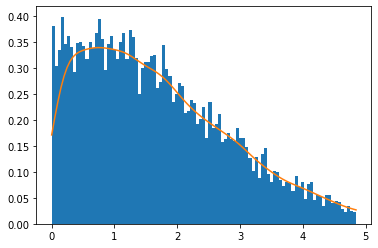

Histogram for F Test feature  9


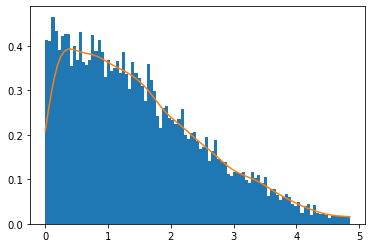

Histogram for F Test feature  10


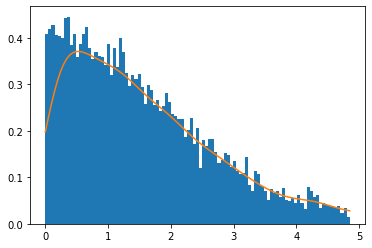

Histogram for F Test feature  11


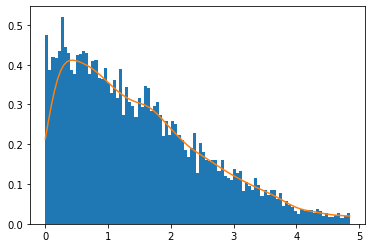

Histogram for F Test feature  12


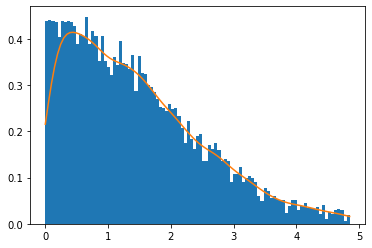

Histogram for F Test feature  13


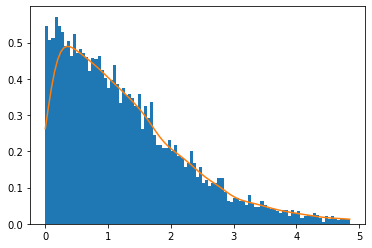

Histogram for F Test feature  14


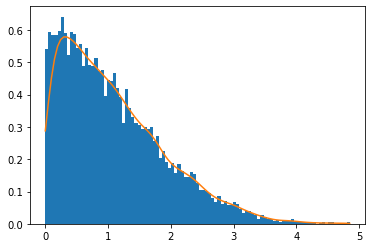

Histogram for F Test feature  15


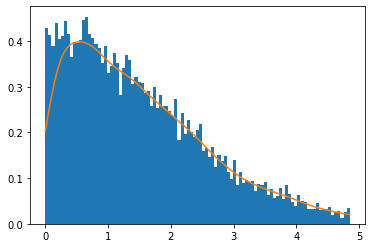

Histogram for F Test feature  16


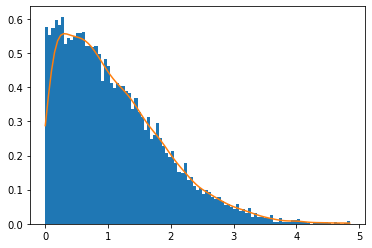

Histogram for F Test feature  17


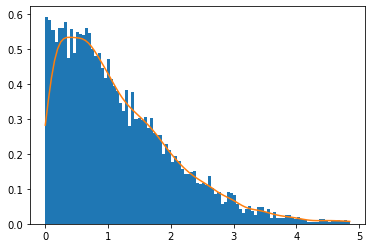

Histogram for F Test feature  18


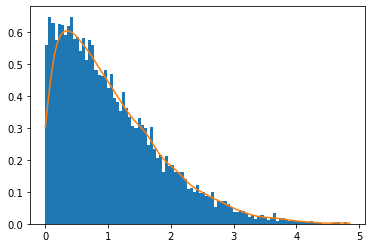

Histogram for F Test feature  19


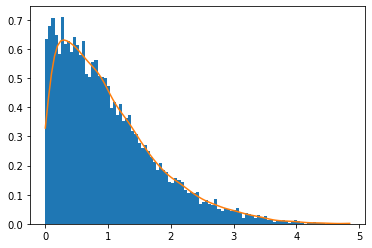

Histogram for F Test feature  20


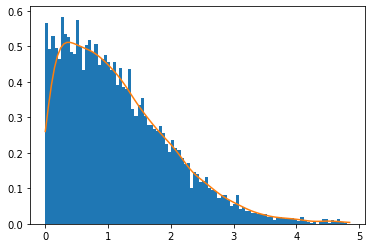

Histogram for F Test feature  21


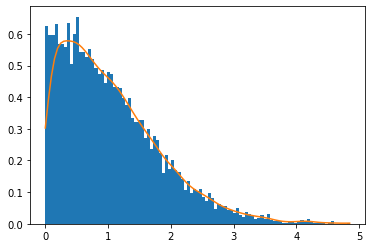

Histogram for F Test feature  22


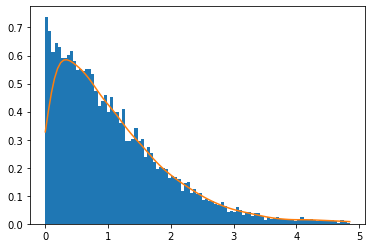

Histogram for F Test feature  23


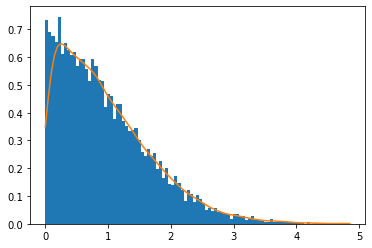

Histogram for F Test feature  24


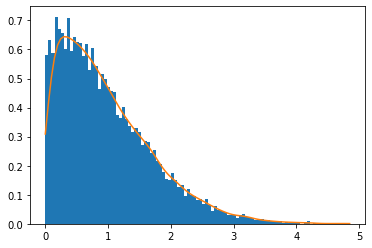

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.5572
LR Accuracy on test data - All features:  0.2679
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5576
Logistic Regression Accuracy on test data - contrasted:  0.2886
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5564
Logistic Regression Accuracy on test data - contrasted:  0.2621
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5135
Logistic Regression Accuracy on test data - contrasted:  0.2053
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5506
Logistic Regression Accuracy on test data - contrasted:  0.2881
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5215
Logistic Regression Accuracy on test data - contrasted:  0.2417
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5462
Logistic Regression Accuracy on test data - contrasted:  0.2477
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5512
Logistic Regression Accuracy on test data - contrasted:  0.2677
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5412
Logistic Regression Accuracy on test data - contrasted:  0.2681
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5475
Logistic Regression Accuracy on test data - contrasted:  0.2593
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.544
Logistic Regression Accuracy on test data - contrasted:  0.259
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5461
Logistic Regression Accuracy on test data - contrasted:  0.2705
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5473
Logistic Regression Accuracy on test data - contrasted:  0.2605
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5429
Logistic Regression Accuracy on test data - contrasted:  0.2769
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.546
Logistic Regression Accuracy on test data - contrasted:  0.2654
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5431
Logistic Regression Accuracy on test data - contrasted:  0.2589
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5535
Logistic Regression Accuracy on test data - contrasted:  0.2671
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5585
Logistic Regression Accuracy on test data - contrasted:  0.2684
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5516
Logistic Regression Accuracy on test data - contrasted:  0.2638
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.555
Logistic Regression Accuracy on test data - contrasted:  0.2698
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5515
Logistic Regression Accuracy on test data - contrasted:  0.2654
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5511
Logistic Regression Accuracy on test data - contrasted:  0.2686
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5528
Logistic Regression Accuracy on test data - contrasted:  0.2627
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.555
Logistic Regression Accuracy on test data - contrasted:  0.2733
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5557
Logistic Regression Accuracy on test data - contrasted:  0.2708
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5554
Logistic Regression Accuracy on test data - contrasted:  0.2661




Results for lamda  0.01

Printing eigenvalues
(512,)
[-1.32051222e+02 -2.21352714e+01 -1.97232966e+01 -1.36934391e+01
 -9.46690191e+00 -8.63388734e+00 -7.66718914e+00 -6.89109569e+00
 -5.78627497e+00 -5.41851578e+00 -4.85554189e+00 -4.33659213e+00
 -3.63647357e+00 -3.14306845e+00 -3.08715611e+00 -2.95904277e+00
 -2.41684314e+00 -2.31519205e+00 -2.16399392e+00 -2.01533026e+00
 -1.91663766e+00 -1.91177725e+00 -1.79618695e+00 -1.63399428e+00
 -1.58095427e+00 -1.51819332e+00 -1.36959727e+00 -1.34524666e+00
 -1.33334450e+00 -1.24464166e+00 -1.16965624e+00 -1.12111811e+00
 -1.05192725e+00 -1.03261082e+00 -1.00335993e+00 -9.89811785e-01
 -8.94810824e-01 -8.80475398e-01 -8.68467654e-01 -8.39065400e-01
 -7.93834322e-01 -7.68948664e-01 -7.24716653e-01 -7.04802698e-01
 -6.77730266e-01 -6.75436978e-01 -6.41292546e-01 -6.05952327e-01
 -6.01511990e-01 -5.694

(512, 512)

array([[ 0.03669575,  0.0051405 , -0.00142328, ..., -0.0084525 ,
         0.00040872, -0.05036686],
       [ 0.06734635,  0.1334611 , -0.07529196, ..., -0.01659648,
         0.00024642,  0.04326318],
       [ 0.02294276,  0.03213933, -0.02646132, ...,  0.00390177,
        -0.00036478, -0.03405651],
       ...,
       [ 0.08318303,  0.04465944,  0.09387367, ..., -0.04513258,
        -0.00069598, -0.01851725],
       [ 0.03862074,  0.06555533,  0.03888304, ..., -0.04099165,
        -0.00017618,  0.10363963],
       [ 0.00637791, -0.00200982, -0.01134237, ..., -0.00840898,
        -0.01422167,  0.02056394]])

Printing least k eigenvalues before removing the zero eigenvalue
[-132.05122162  -22.13527143  -19.72329657  -13.69343914   -9.46690191
   -8.63388734   -7.66718914   -6.89109569   -5.78627497   -5.41851578
   -4.85554189   -4.33659213   -3.63647357   -3.14306845   -3.08715611
   -2.95904277   -2.41684314   -2.31519205   -2.16399392   -2.01533026
   -1.91663766   -1.91177725   -1.79618695   -1.63399428   -1.58095427]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-132.05122162  -22.13527143  -19.72329657  -13.69343914   -9.46690191
   -8.63388734   -7.66718914   -6.89109569   -5.78627497   -5.41851578
   -4.85554189   -4.33659213   -3.63647357   -3.14306845   -3.08715611
   -2.95904277   -2.41684314   -2.31519205   -2.16399392   -2.01533026
   -1.91663766   -1.91177725   -1.79618695   -1.63399428]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.021970,3.245278,0.001367,12.068979,0.537881,1.862454,0.206292,0.229261,4.142621,2.033028,...,1.465125,1.082365,0.723370,0.322200,1.833556,3.088026,1.504578,1.825652,2.445480,0.494490
1,3.200015,3.320917,3.558206,11.291467,0.714560,4.263010,3.926235,0.999208,1.249827,0.817467,...,1.205212,0.148406,3.232826,0.442078,0.135929,2.752068,0.635638,0.786575,1.337552,0.186174
2,3.194737,3.659510,2.601181,7.394175,2.197649,2.425118,3.210375,3.625916,1.321095,1.948270,...,0.299502,2.001039,0.050189,0.483404,1.555351,0.320651,1.488415,1.692002,1.476257,0.397566
3,1.697847,2.402155,2.518923,4.828247,2.787152,2.852411,0.673328,0.189695,0.409138,0.429138,...,0.128909,1.394164,0.038705,0.961618,1.463950,0.551377,0.216558,0.630484,0.033523,1.436015
4,1.591675,1.566393,6.750493,5.386520,4.729346,3.511188,1.373084,0.492986,0.801202,1.739786,...,1.345052,0.618639,0.094378,1.323247,1.591982,1.886921,0.824896,2.178269,0.016323,0.482537


Histogram for F Test feature  0


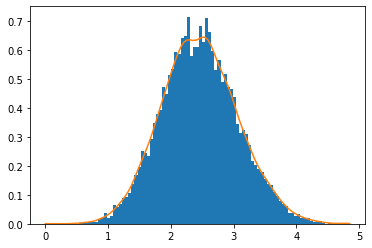

Histogram for F Test feature  1


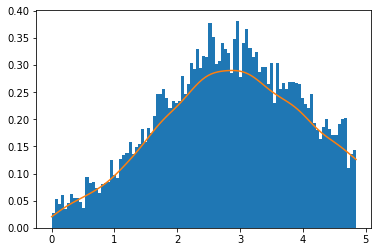

Histogram for F Test feature  2


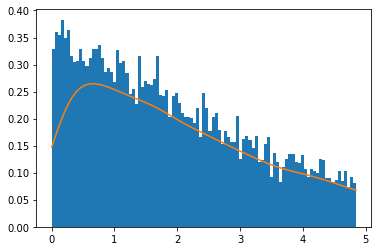

Histogram for F Test feature  3


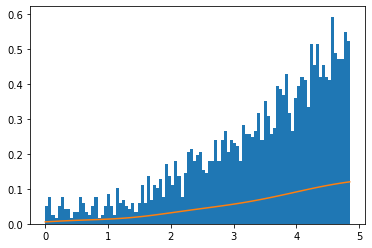

Histogram for F Test feature  4


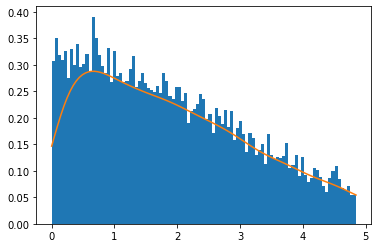

Histogram for F Test feature  5


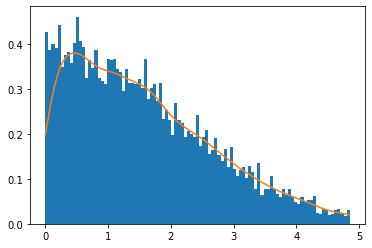

Histogram for F Test feature  6


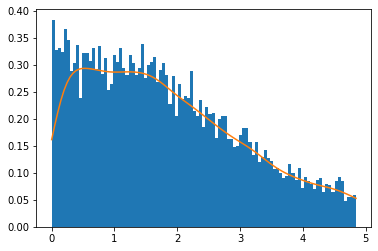

Histogram for F Test feature  7


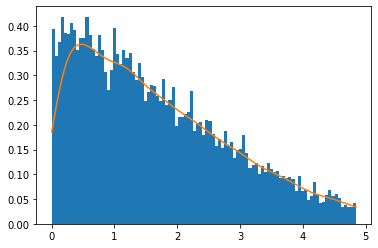

Histogram for F Test feature  8


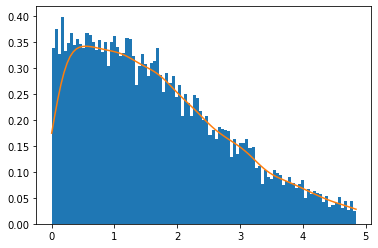

Histogram for F Test feature  9


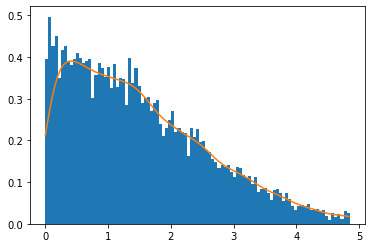

Histogram for F Test feature  10


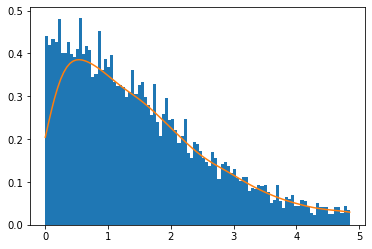

Histogram for F Test feature  11


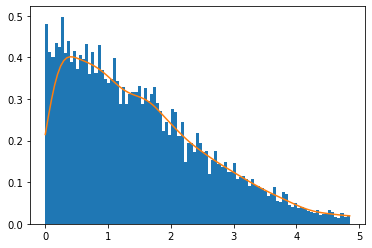

Histogram for F Test feature  12


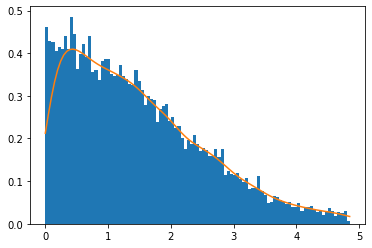

Histogram for F Test feature  13


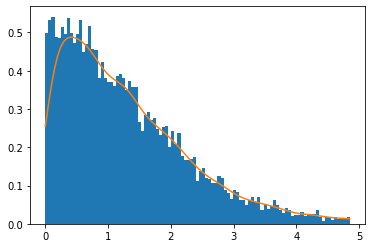

Histogram for F Test feature  14


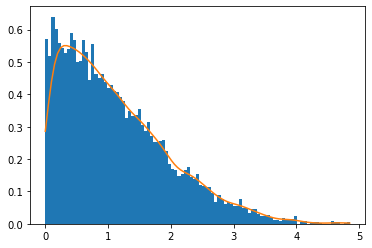

Histogram for F Test feature  15


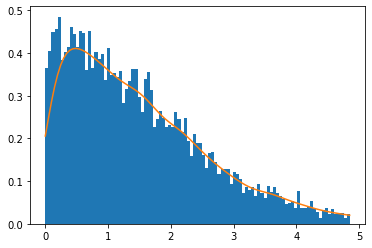

Histogram for F Test feature  16


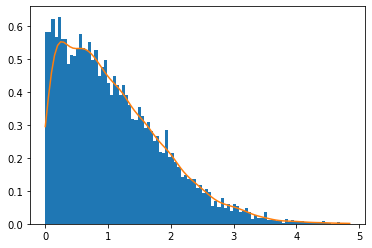

Histogram for F Test feature  17


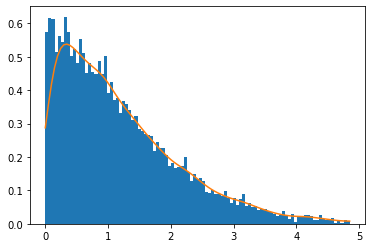

Histogram for F Test feature  18


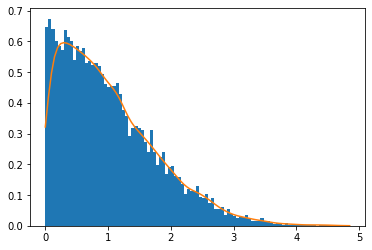

Histogram for F Test feature  19


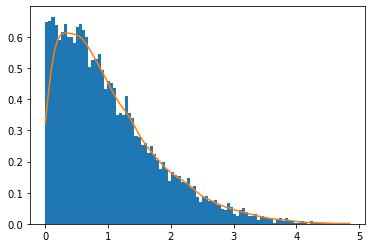

Histogram for F Test feature  20


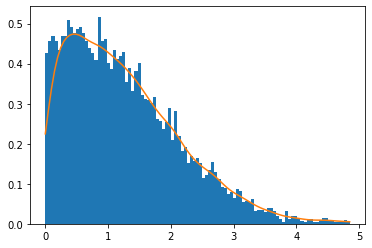

Histogram for F Test feature  21


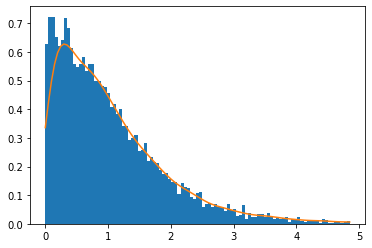

Histogram for F Test feature  22


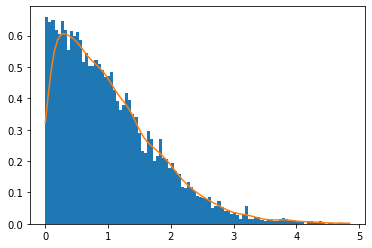

Histogram for F Test feature  23


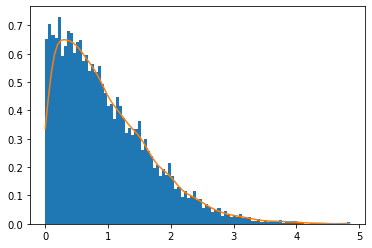

Histogram for F Test feature  24


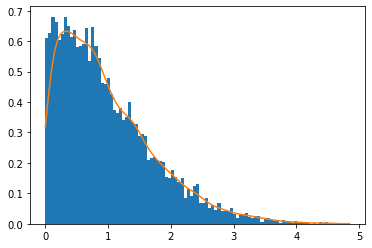

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.5576
LR Accuracy on test data - All features:  0.2647
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.556
Logistic Regression Accuracy on test data - contrasted:  0.2877
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5571
Logistic Regression Accuracy on test data - contrasted:  0.2598
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5097
Logistic Regression Accuracy on test data - contrasted:  0.2034
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5514
Logistic Regression Accuracy on test data - contrasted:  0.2866
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5202
Logistic Regression Accuracy on test data - contrasted:  0.239
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5454
Logistic Regression Accuracy on test data - contrasted:  0.2447
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5519
Logistic Regression Accuracy on test data - contrasted:  0.2661
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5421
Logistic Regression Accuracy on test data - contrasted:  0.266
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5474
Logistic Regression Accuracy on test data - contrasted:  0.2543
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5411
Logistic Regression Accuracy on test data - contrasted:  0.2567
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5483
Logistic Regression Accuracy on test data - contrasted:  0.2681
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5456
Logistic Regression Accuracy on test data - contrasted:  0.2594
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5445
Logistic Regression Accuracy on test data - contrasted:  0.2701
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5465
Logistic Regression Accuracy on test data - contrasted:  0.2651
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5428
Logistic Regression Accuracy on test data - contrasted:  0.2608
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5517
Logistic Regression Accuracy on test data - contrasted:  0.2628
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5585
Logistic Regression Accuracy on test data - contrasted:  0.2645
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5514
Logistic Regression Accuracy on test data - contrasted:  0.2623
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.553
Logistic Regression Accuracy on test data - contrasted:  0.267
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5512
Logistic Regression Accuracy on test data - contrasted:  0.2625
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5524
Logistic Regression Accuracy on test data - contrasted:  0.2713
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5537
Logistic Regression Accuracy on test data - contrasted:  0.2695
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.552
Logistic Regression Accuracy on test data - contrasted:  0.2576
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5537
Logistic Regression Accuracy on test data - contrasted:  0.2655
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5547
Logistic Regression Accuracy on test data - contrasted:  0.2611




Results for lamda  0.001

Printing eigenvalues
(512,)
[-1.32817400e+02 -2.22150008e+01 -1.97822890e+01 -1.37655288e+01
 -9.49879387e+00 -8.67559252e+00 -7.69482622e+00 -6.91296625e+00
 -5.80981157e+00 -5.44562597e+00 -4.87685145e+00 -4.35700524e+00
 -3.65512351e+00 -3.15468236e+00 -3.10469519e+00 -2.96853789e+00
 -2.42951195e+00 -2.32389029e+00 -2.17445128e+00 -2.02759625e+00
 -1.92926306e+00 -1.92093167e+00 -1.80425173e+00 -1.64311596e+00
 -1.59035728e+00 -1.52691286e+00 -1.37932819e+00 -1.35339913e+00
 -1.34115961e+00 -1.25224728e+00 -1.17617155e+00 -1.12787674e+00
 -1.05896691e+00 -1.04435064e+00 -1.00998118e+00 -9.96374483e-01
 -9.00766432e-01 -8.86567634e-01 -8.74759885e-01 -8.46433139e-01
 -7.98258453e-01 -7.75350798e-01 -7.28785470e-01 -7.09028725e-01
 -6.83613537e-01 -6.80460230e-01 -6.47735455e-01 -6.11264478e-01
 -6.06230115e-01 -5.73

(512, 512)

array([[ 0.03669096,  0.00518779, -0.00144069, ..., -0.00221485,
         0.00039483, -0.05036686],
       [ 0.06734992,  0.13374999, -0.07423883, ..., -0.00230704,
         0.00016336,  0.04326318],
       [ 0.02296789,  0.0322535 , -0.02620861, ..., -0.00098239,
        -0.00031548, -0.03405651],
       ...,
       [ 0.08335103,  0.04424857,  0.09348742, ..., -0.00557176,
        -0.00073279, -0.01851725],
       [ 0.03854577,  0.06526394,  0.03937898, ..., -0.0063605 ,
        -0.00027658,  0.10363963],
       [ 0.00642019, -0.00195583, -0.01144424, ...,  0.00322207,
        -0.01431683,  0.02056394]])

Printing least k eigenvalues before removing the zero eigenvalue
[-132.8173998   -22.21500081  -19.78228897  -13.76552877   -9.49879387
   -8.67559252   -7.69482622   -6.91296625   -5.80981157   -5.44562597
   -4.87685145   -4.35700524   -3.65512351   -3.15468236   -3.10469519
   -2.96853789   -2.42951195   -2.32389029   -2.17445128   -2.02759625
   -1.92926306   -1.92093167   -1.80425173   -1.64311596   -1.59035728]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-132.8173998   -22.21500081  -19.78228897  -13.76552877   -9.49879387
   -8.67559252   -7.69482622   -6.91296625   -5.80981157   -5.44562597
   -4.87685145   -4.35700524   -3.65512351   -3.15468236   -3.10469519
   -2.96853789   -2.42951195   -2.32389029   -2.17445128   -2.02759625
   -1.92926306   -1.92093167   -1.80425173   -1.64311596]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.021970,3.262411,0.060108,12.067271,0.503791,1.854968,0.207154,0.181801,4.156744,2.037119,...,1.475028,1.095612,0.707419,0.325604,1.880465,3.103184,1.159547,1.985640,2.437386,0.520733
1,3.200015,3.336393,3.622000,11.273514,0.680204,4.243203,3.934927,0.986376,1.264806,0.807594,...,1.127468,0.132246,3.215949,0.519961,0.117605,2.800966,0.608717,0.699360,1.330672,0.177909
2,3.194737,3.666476,2.635054,7.359781,2.220912,2.419634,3.219593,3.648146,1.309745,1.952751,...,0.278799,2.004826,0.036168,0.499339,1.576724,0.369595,1.337113,1.811412,1.486047,0.430495
3,1.697847,2.404910,2.541182,4.804082,2.807726,2.846062,0.669929,0.186953,0.404896,0.426974,...,0.186209,1.390476,0.007501,0.968853,1.483018,0.556425,0.148290,0.642846,0.048840,1.393910
4,1.591675,1.570087,6.738558,5.392003,4.742134,3.505355,1.379584,0.499218,0.789994,1.738368,...,1.358151,0.612649,0.134038,1.318537,1.614914,1.810246,1.126941,2.066585,0.036105,0.457130


Histogram for F Test feature  0


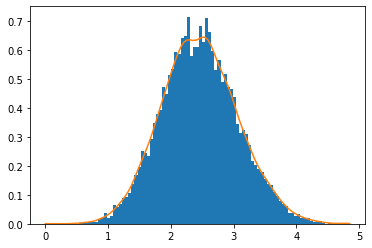

Histogram for F Test feature  1


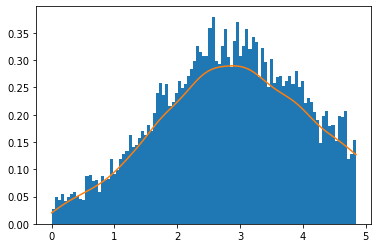

Histogram for F Test feature  2


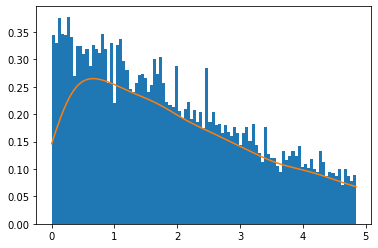

Histogram for F Test feature  3


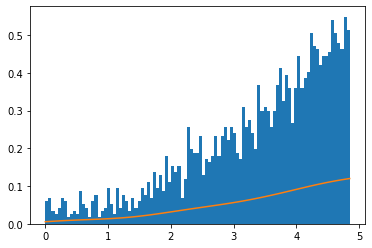

Histogram for F Test feature  4


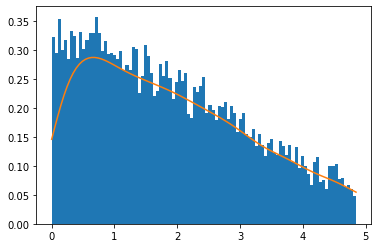

Histogram for F Test feature  5


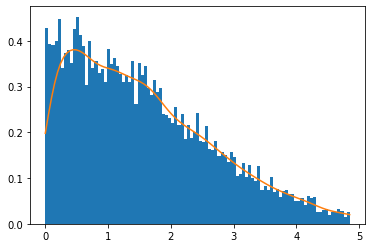

Histogram for F Test feature  6


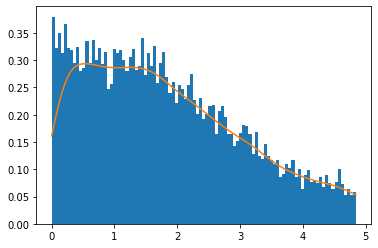

Histogram for F Test feature  7


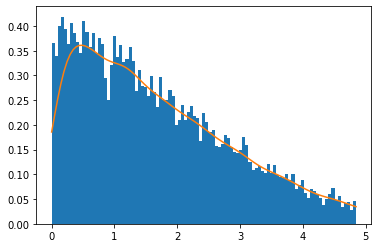

Histogram for F Test feature  8


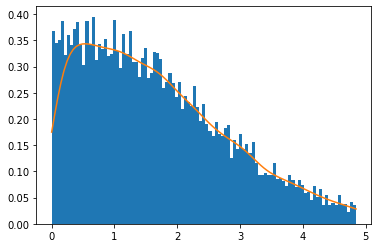

Histogram for F Test feature  9


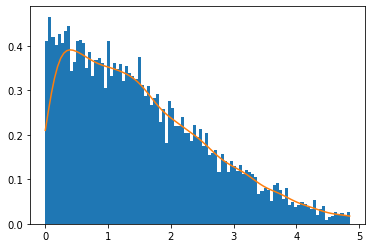

Histogram for F Test feature  10


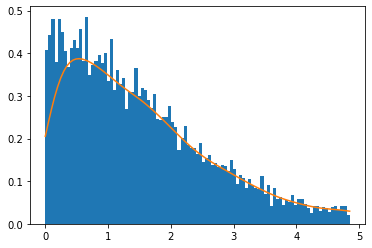

Histogram for F Test feature  11


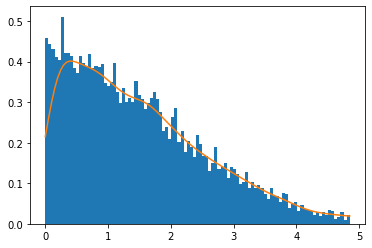

Histogram for F Test feature  12


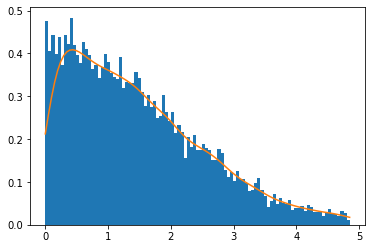

Histogram for F Test feature  13


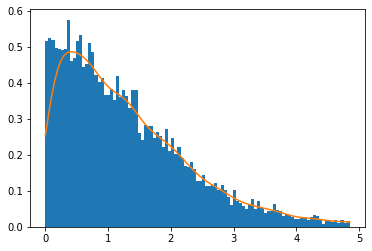

Histogram for F Test feature  14


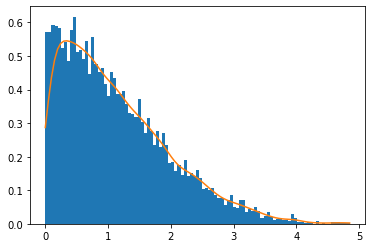

Histogram for F Test feature  15


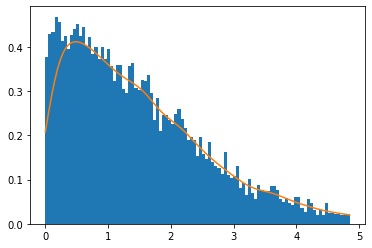

Histogram for F Test feature  16


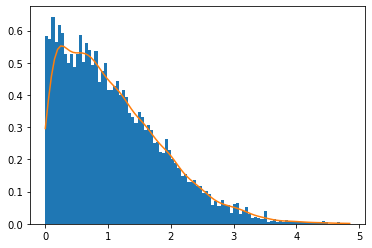

Histogram for F Test feature  17


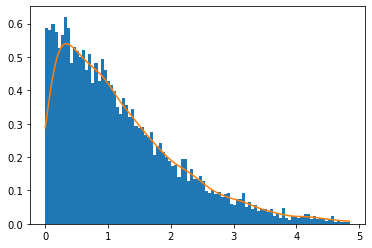

Histogram for F Test feature  18


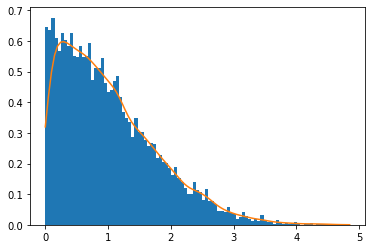

Histogram for F Test feature  19


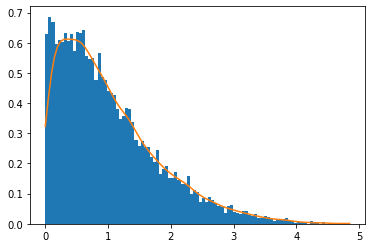

Histogram for F Test feature  20


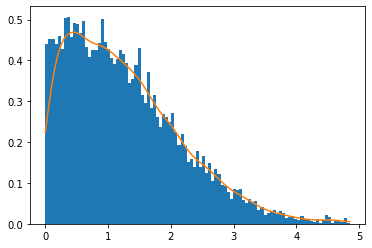

Histogram for F Test feature  21


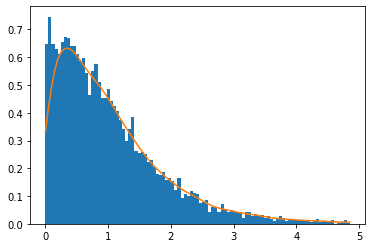

Histogram for F Test feature  22


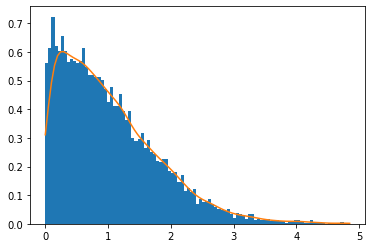

Histogram for F Test feature  23


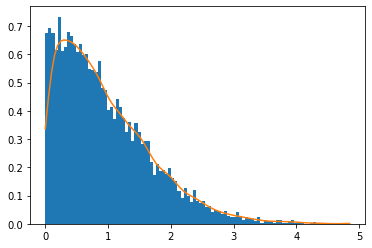

Histogram for F Test feature  24


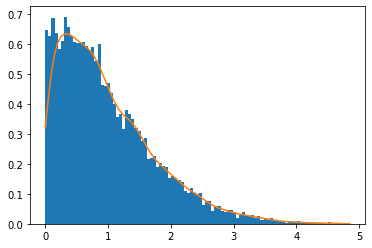

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.5581
LR Accuracy on test data - All features:  0.2649
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5565
Logistic Regression Accuracy on test data - contrasted:  0.2891
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5565
Logistic Regression Accuracy on test data - contrasted:  0.2571
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5093
Logistic Regression Accuracy on test data - contrasted:  0.2043
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5517
Logistic Regression Accuracy on test data - contrasted:  0.2846
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5201
Logistic Regression Accuracy on test data - contrasted:  0.243
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5455
Logistic Regression Accuracy on test data - contrasted:  0.2446
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.552
Logistic Regression Accuracy on test data - contrasted:  0.265
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5425
Logistic Regression Accuracy on test data - contrasted:  0.2693
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5476
Logistic Regression Accuracy on test data - contrasted:  0.2539
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5419
Logistic Regression Accuracy on test data - contrasted:  0.2569
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5488
Logistic Regression Accuracy on test data - contrasted:  0.268
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5455
Logistic Regression Accuracy on test data - contrasted:  0.2592
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5442
Logistic Regression Accuracy on test data - contrasted:  0.2674
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5479
Logistic Regression Accuracy on test data - contrasted:  0.2641
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.544
Logistic Regression Accuracy on test data - contrasted:  0.2584
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5526
Logistic Regression Accuracy on test data - contrasted:  0.2644
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5575
Logistic Regression Accuracy on test data - contrasted:  0.264
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5515
Logistic Regression Accuracy on test data - contrasted:  0.2619
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.553
Logistic Regression Accuracy on test data - contrasted:  0.2692
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5513
Logistic Regression Accuracy on test data - contrasted:  0.2621
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.552
Logistic Regression Accuracy on test data - contrasted:  0.271
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5541
Logistic Regression Accuracy on test data - contrasted:  0.2653
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5528
Logistic Regression Accuracy on test data - contrasted:  0.2572
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5545
Logistic Regression Accuracy on test data - contrasted:  0.2664
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5549
Logistic Regression Accuracy on test data - contrasted:  0.2612




Results for lamda  0.0001

Printing eigenvalues
(512,)
[-1.32894099e+02 -2.22229928e+01 -1.97881898e+01 -1.37727453e+01
 -9.50198412e+00 -8.67977088e+00 -7.69759973e+00 -6.91515079e+00
 -5.81218102e+00 -5.44833002e+00 -4.87898466e+00 -4.35905188e+00
 -3.65699347e+00 -3.15584850e+00 -3.10645175e+00 -2.96948850e+00
 -2.43078435e+00 -2.32476091e+00 -2.17550356e+00 -2.02885086e+00
 -1.93052483e+00 -1.92184275e+00 -1.80505996e+00 -1.64403604e+00
 -1.59129607e+00 -1.52779037e+00 -1.38031773e+00 -1.35421139e+00
 -1.34193914e+00 -1.25300918e+00 -1.17683225e+00 -1.12855771e+00
 -1.05972551e+00 -1.04550920e+00 -1.01064473e+00 -9.97026113e-01
 -9.01366499e-01 -8.87177338e-01 -8.75401633e-01 -8.47177559e-01
 -7.98701117e-01 -7.75993850e-01 -7.29192429e-01 -7.09455462e-01
 -6.84229684e-01 -6.80950772e-01 -6.48388596e-01 -6.11799393e-01
 -6.06701901e-01 -5.7

(512, 512)

array([[ 0.03669047,  0.00519251, -0.0014424 , ..., -0.00221111,
         0.00039485, -0.05036686],
       [ 0.06735025,  0.13377831, -0.07413345, ..., -0.00230636,
         0.00015872,  0.04326318],
       [ 0.02297038,  0.03226477, -0.02618329, ..., -0.00098701,
        -0.00031127, -0.03405651],
       ...,
       [ 0.08336773,  0.04420786,  0.09344866, ..., -0.00556268,
        -0.0007267 , -0.01851725],
       [ 0.0385383 ,  0.06523471,  0.03942832, ..., -0.00639622,
        -0.00027843,  0.10363963],
       [ 0.0064244 , -0.0019504 , -0.01145438, ...,  0.0032265 ,
        -0.01432444,  0.02056394]])

Printing least k eigenvalues before removing the zero eigenvalue
[-132.89409944  -22.2229928   -19.78818983  -13.77274532   -9.50198412
   -8.67977088   -7.69759973   -6.91515079   -5.81218102   -5.44833002
   -4.87898466   -4.35905188   -3.65699347   -3.1558485    -3.10645175
   -2.9694885    -2.43078435   -2.32476091   -2.17550356   -2.02885086
   -1.93052483   -1.92184275   -1.80505996   -1.64403604   -1.59129607]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-132.89409944  -22.2229928   -19.78818983  -13.77274532   -9.50198412
   -8.67977088   -7.69759973   -6.91515079   -5.81218102   -5.44833002
   -4.87898466   -4.35905188   -3.65699347   -3.1558485    -3.10645175
   -2.9694885    -2.43078435   -2.32476091   -2.17550356   -2.02885086
   -1.93052483   -1.92184275   -1.80505996   -1.64403604]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.021970,3.264113,0.065961,12.067069,0.500366,1.854227,0.207241,0.177063,4.158138,2.037500,...,1.476028,1.096919,0.705826,0.325886,1.885139,3.104160,1.132162,1.994220,2.436563,0.523291
1,3.200015,3.337930,3.628352,11.271688,0.676747,4.241226,3.935794,0.985084,1.266304,0.806593,...,1.119178,0.130652,3.214186,0.527604,0.115718,2.805787,0.602019,0.693781,1.329996,0.177100
2,3.194737,3.667167,2.638415,7.356328,2.223239,2.419087,3.220506,3.650361,1.308619,1.953144,...,0.276495,2.005202,0.034767,0.500937,1.578867,0.374695,1.329060,1.816983,1.487022,0.433785
3,1.697847,2.405183,2.543388,4.801655,2.809786,2.845425,0.669589,0.186688,0.404464,0.426754,...,0.192381,1.390108,0.004422,0.969553,1.484924,0.556942,0.144122,0.643058,0.050372,1.389606
4,1.591675,1.570453,6.737372,5.392540,4.743396,3.504777,1.380229,0.499854,0.788878,1.738184,...,1.359503,0.612060,0.137905,1.318002,1.617168,1.802060,1.147667,2.058271,0.038047,0.454576


Histogram for F Test feature  0


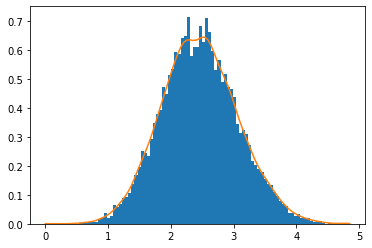

Histogram for F Test feature  1


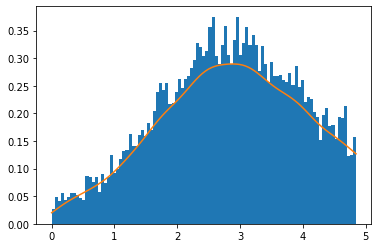

Histogram for F Test feature  2


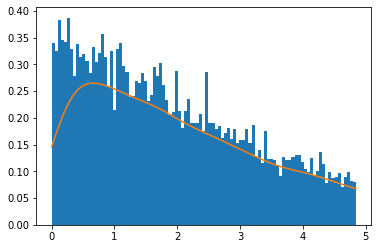

Histogram for F Test feature  3


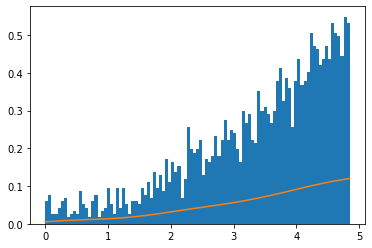

Histogram for F Test feature  4


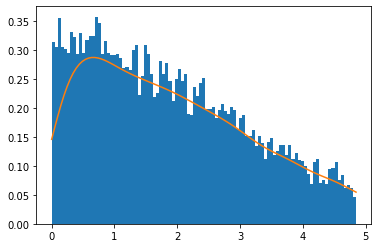

Histogram for F Test feature  5


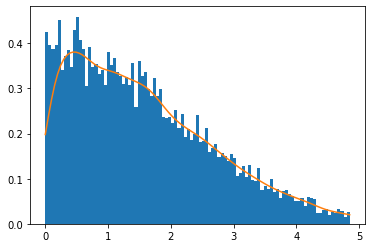

Histogram for F Test feature  6


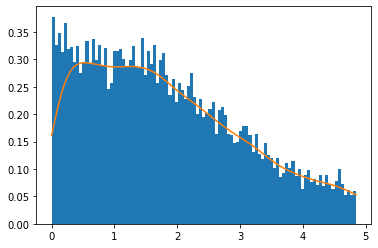

Histogram for F Test feature  7


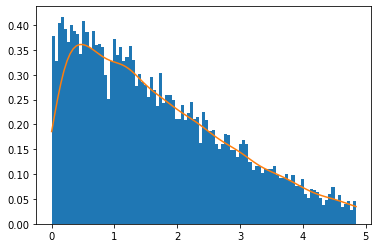

Histogram for F Test feature  8


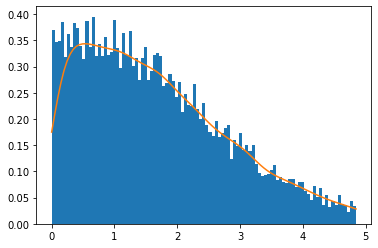

Histogram for F Test feature  9


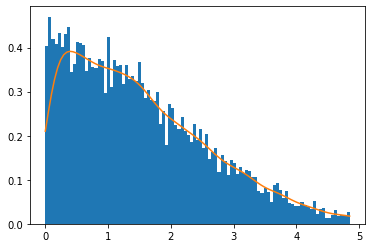

Histogram for F Test feature  10


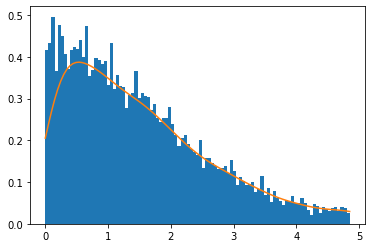

Histogram for F Test feature  11


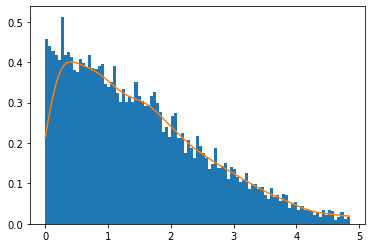

Histogram for F Test feature  12


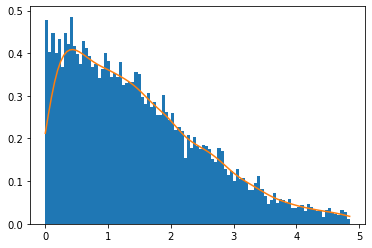

Histogram for F Test feature  13


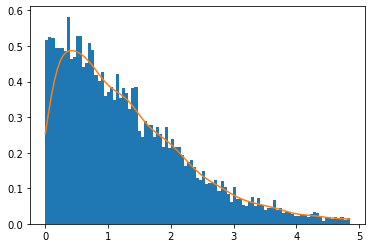

Histogram for F Test feature  14


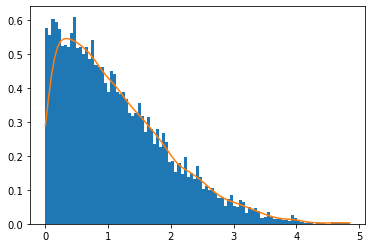

Histogram for F Test feature  15


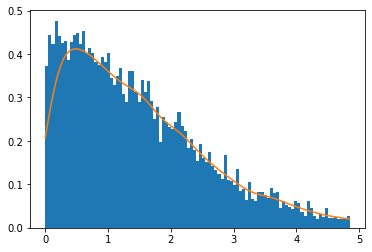

Histogram for F Test feature  16


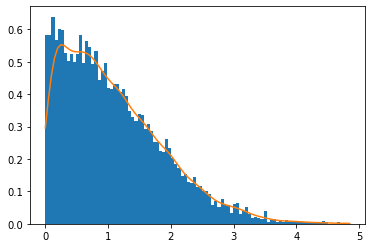

Histogram for F Test feature  17


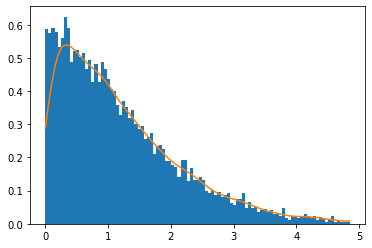

Histogram for F Test feature  18


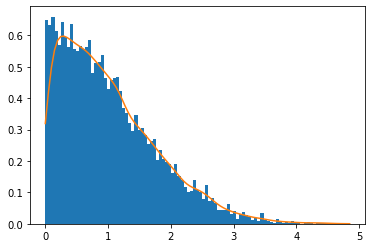

Histogram for F Test feature  19


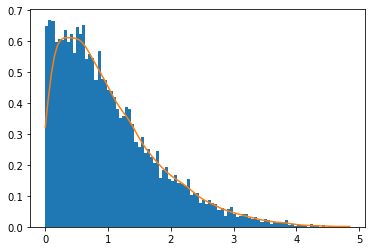

Histogram for F Test feature  20


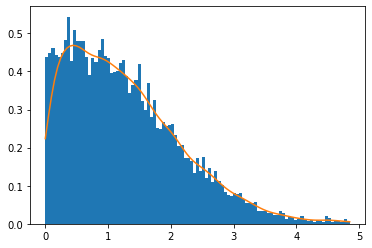

Histogram for F Test feature  21


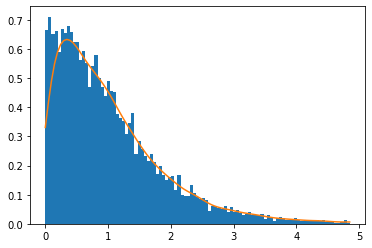

Histogram for F Test feature  22


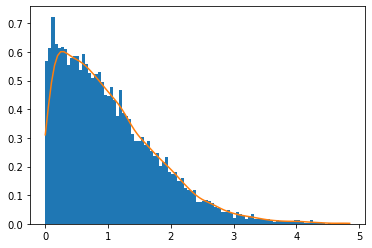

Histogram for F Test feature  23


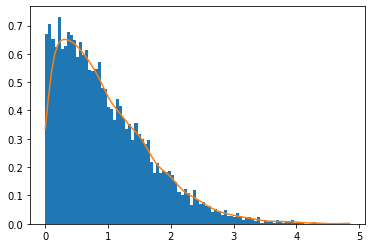

Histogram for F Test feature  24


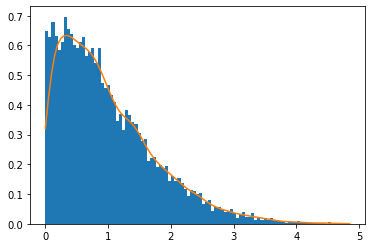

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.5572
LR Accuracy on test data - All features:  0.264
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5576
Logistic Regression Accuracy on test data - contrasted:  0.2877
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5564
Logistic Regression Accuracy on test data - contrasted:  0.2586
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5089
Logistic Regression Accuracy on test data - contrasted:  0.205
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5517
Logistic Regression Accuracy on test data - contrasted:  0.291
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5203
Logistic Regression Accuracy on test data - contrasted:  0.2415
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5451
Logistic Regression Accuracy on test data - contrasted:  0.2449
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5511
Logistic Regression Accuracy on test data - contrasted:  0.2653
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.542
Logistic Regression Accuracy on test data - contrasted:  0.2688
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5471
Logistic Regression Accuracy on test data - contrasted:  0.2543
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5406
Logistic Regression Accuracy on test data - contrasted:  0.257
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5491
Logistic Regression Accuracy on test data - contrasted:  0.2684
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5463
Logistic Regression Accuracy on test data - contrasted:  0.2602
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5436
Logistic Regression Accuracy on test data - contrasted:  0.265
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5474
Logistic Regression Accuracy on test data - contrasted:  0.2644
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5434
Logistic Regression Accuracy on test data - contrasted:  0.258
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5517
Logistic Regression Accuracy on test data - contrasted:  0.2643
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.558
Logistic Regression Accuracy on test data - contrasted:  0.2646
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5522
Logistic Regression Accuracy on test data - contrasted:  0.2621
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5532
Logistic Regression Accuracy on test data - contrasted:  0.2658
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5505
Logistic Regression Accuracy on test data - contrasted:  0.2622
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5536
Logistic Regression Accuracy on test data - contrasted:  0.273
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5544
Logistic Regression Accuracy on test data - contrasted:  0.266
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5528
Logistic Regression Accuracy on test data - contrasted:  0.261
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5546
Logistic Regression Accuracy on test data - contrasted:  0.2674
Accuracy for without feature  24


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5537
Logistic Regression Accuracy on test data - contrasted:  0.2595




Results for lamda  1e-10

Printing eigenvalues
(512,)
[-1.32902623e+02 -2.22238810e+01 -1.97888455e+01 -1.37735472e+01
 -9.50233861e+00 -8.68023523e+00 -7.69790800e+00 -6.91539349e+00
 -5.81244447e+00 -5.44863039e+00 -4.87922171e+00 -4.35927935e+00
 -3.65720130e+00 -3.15597813e+00 -3.10664695e+00 -2.96959414e+00
 -2.43092579e+00 -2.32485766e+00 -2.17562056e+00 -2.02899058e+00
 -1.93066499e+00 -1.92194396e+00 -1.80514979e+00 -1.64413836e+00
 -1.59140036e+00 -1.52788793e+00 -1.38042786e+00 -1.35430163e+00
 -1.34202573e+00 -1.25309385e+00 -1.17690577e+00 -1.12863343e+00
 -1.05981066e+00 -1.04563752e+00 -1.01071847e+00 -9.97098467e-01
 -9.01433224e-01 -8.87245088e-01 -8.75473092e-01 -8.47260350e-01
 -7.98750304e-01 -7.76065329e-01 -7.29237648e-01 -7.09502925e-01
 -6.84298435e-01 -6.81005178e-01 -6.48461262e-01 -6.11858866e-01
 -6.06754323e-01 -5.74

(512, 512)

array([[ 0.03669041,  0.00519303, -0.00144259, ..., -0.00221062,
         0.00039485, -0.05036686],
       [ 0.06735029,  0.13378145, -0.07412174, ..., -0.00230616,
         0.00015821,  0.04326318],
       [ 0.02297066,  0.03226602, -0.02618048, ..., -0.00098753,
        -0.00031081, -0.03405651],
       ...,
       [ 0.08336959,  0.04420334,  0.09344435, ..., -0.00556135,
        -0.00072602, -0.01851725],
       [ 0.03853747,  0.06523146,  0.03943379, ..., -0.0063998 ,
        -0.00027863,  0.10363963],
       [ 0.00642486, -0.00194979, -0.01145551, ...,  0.00322706,
        -0.01432528,  0.02056394]])

Printing least k eigenvalues before removing the zero eigenvalue
[-132.90262252  -22.22388101  -19.78884549  -13.77354725   -9.50233861
   -8.68023523   -7.697908     -6.91539349   -5.81244447   -5.44863039
   -4.87922171   -4.35927935   -3.6572013    -3.15597813   -3.10664695
   -2.96959414   -2.43092579   -2.32485766   -2.17562056   -2.02899058
   -1.93066499   -1.92194396   -1.80514979   -1.64413836   -1.59140036]
Printing least k-1 eigenvalues after removing the zero eigenvalue
[-132.90262252  -22.22388101  -19.78884549  -13.77354725   -9.50233861
   -8.68023523   -7.697908     -6.91539349   -5.81244447   -5.44863039
   -4.87922171   -4.35927935   -3.6572013    -3.15597813   -3.10664695
   -2.96959414   -2.43092579   -2.32485766   -2.17562056   -2.02899058
   -1.93066499   -1.92194396   -1.80514979   -1.64413836]
Printing non zero indeces of the least k-1 eigenvalues
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Printing the delta matrix


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.021970,3.264302,0.066611,12.067046,0.499986,1.854144,0.207251,0.176537,4.158293,2.037542,...,1.476139,1.097064,0.705649,0.325917,1.885658,3.104262,1.129165,1.995129,2.436471,0.523574
1,3.200015,3.338101,3.629057,11.271484,0.676363,4.241006,3.935890,0.984941,1.266471,0.806481,...,1.118250,0.130475,3.213990,0.528451,0.115508,2.806322,0.601248,0.693182,1.329921,0.177010
2,3.194737,3.667244,2.638788,7.355944,2.223498,2.419027,3.220608,3.650607,1.308494,1.953187,...,0.276236,2.005244,0.034611,0.501115,1.579105,0.375264,1.328211,1.817564,1.487130,0.434150
3,1.697847,2.405213,2.543633,4.801385,2.810015,2.845354,0.669551,0.186658,0.404416,0.426729,...,0.193073,1.390067,0.004080,0.969631,1.485136,0.556999,0.143675,0.643076,0.050542,1.389126
4,1.591675,1.570493,6.737241,5.392599,4.743536,3.504713,1.380301,0.499925,0.788754,1.738163,...,1.359653,0.611995,0.138333,1.317941,1.617418,1.801144,1.149911,2.057369,0.038262,0.454292


Histogram for F Test feature  0


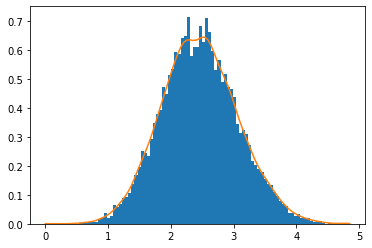

Histogram for F Test feature  1


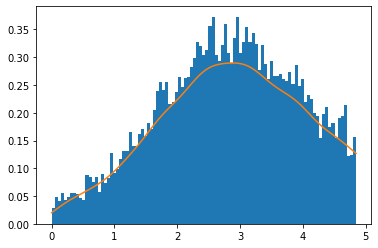

Histogram for F Test feature  2


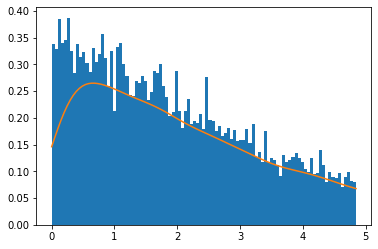

Histogram for F Test feature  3


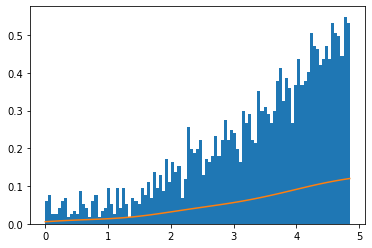

Histogram for F Test feature  4


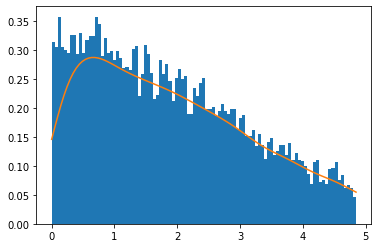

Histogram for F Test feature  5


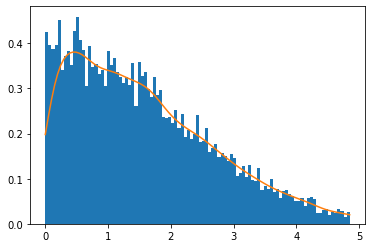

Histogram for F Test feature  6


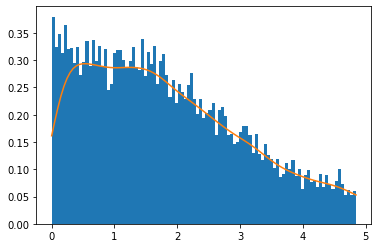

Histogram for F Test feature  7


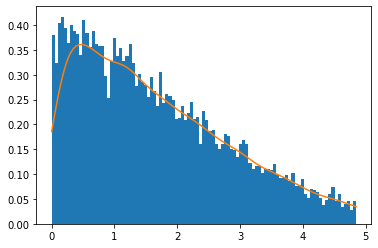

Histogram for F Test feature  8


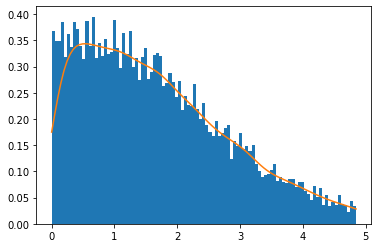

Histogram for F Test feature  9


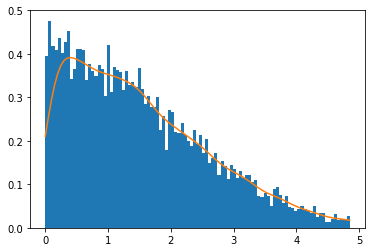

Histogram for F Test feature  10


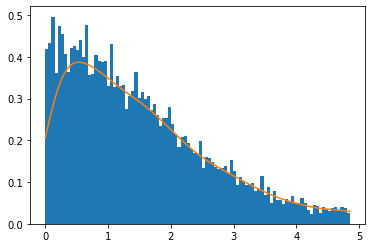

Histogram for F Test feature  11


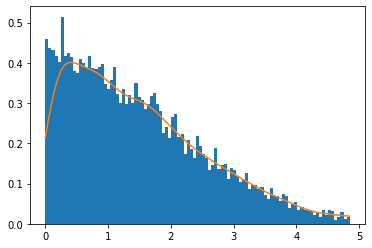

Histogram for F Test feature  12


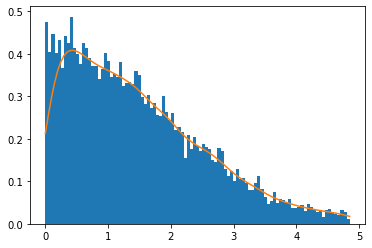

Histogram for F Test feature  13


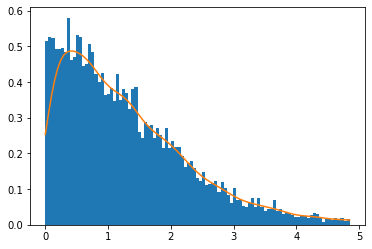

Histogram for F Test feature  14


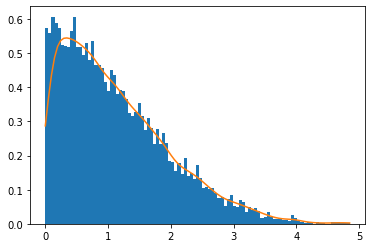

Histogram for F Test feature  15


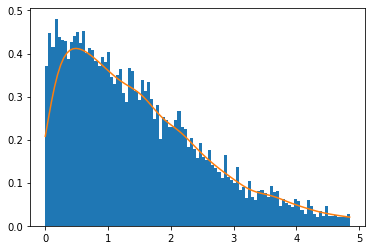

Histogram for F Test feature  16


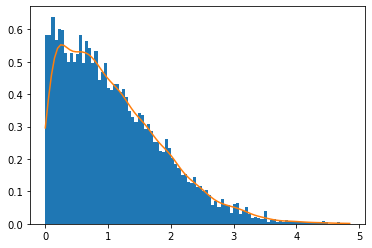

Histogram for F Test feature  17


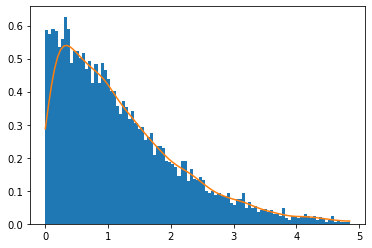

Histogram for F Test feature  18


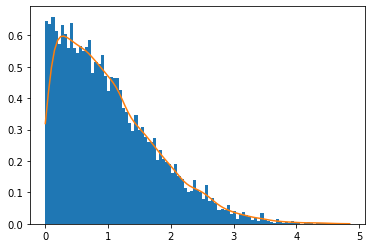

Histogram for F Test feature  19


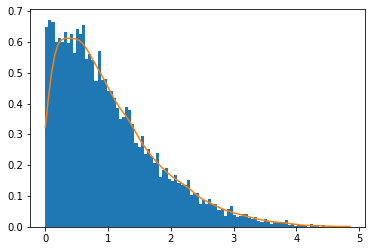

Histogram for F Test feature  20


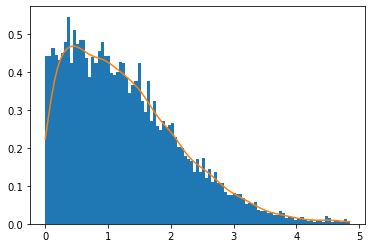

Histogram for F Test feature  21


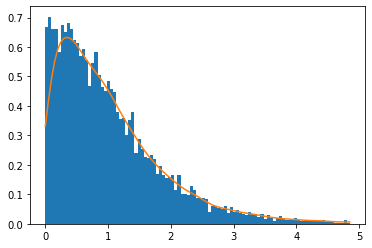

Histogram for F Test feature  22


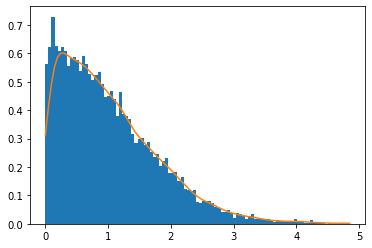

Histogram for F Test feature  23


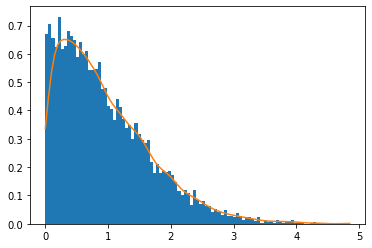

Histogram for F Test feature  24


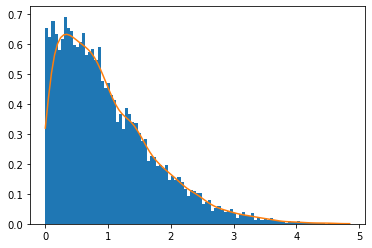

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy within training data - All features :  0.5575
LR Accuracy on test data - All features:  0.2647
Accuracy for without feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5559
Logistic Regression Accuracy on test data - contrasted:  0.2885
Accuracy for without feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5571
Logistic Regression Accuracy on test data - contrasted:  0.259
Accuracy for without feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5096
Logistic Regression Accuracy on test data - contrasted:  0.2049
Accuracy for without feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.554
Logistic Regression Accuracy on test data - contrasted:  0.2987
Accuracy for without feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5198
Logistic Regression Accuracy on test data - contrasted:  0.2408
Accuracy for without feature  5


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5453
Logistic Regression Accuracy on test data - contrasted:  0.2446
Accuracy for without feature  6


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5516
Logistic Regression Accuracy on test data - contrasted:  0.2652
Accuracy for without feature  7


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5431
Logistic Regression Accuracy on test data - contrasted:  0.2671
Accuracy for without feature  8


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5481
Logistic Regression Accuracy on test data - contrasted:  0.254
Accuracy for without feature  9


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5415
Logistic Regression Accuracy on test data - contrasted:  0.2571
Accuracy for without feature  10


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5485
Logistic Regression Accuracy on test data - contrasted:  0.2681
Accuracy for without feature  11


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5463
Logistic Regression Accuracy on test data - contrasted:  0.26
Accuracy for without feature  12


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5432
Logistic Regression Accuracy on test data - contrasted:  0.2663
Accuracy for without feature  13


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5472
Logistic Regression Accuracy on test data - contrasted:  0.2647
Accuracy for without feature  14


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5439
Logistic Regression Accuracy on test data - contrasted:  0.2604
Accuracy for without feature  15


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5521
Logistic Regression Accuracy on test data - contrasted:  0.2635
Accuracy for without feature  16


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5574
Logistic Regression Accuracy on test data - contrasted:  0.2645
Accuracy for without feature  17


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5518
Logistic Regression Accuracy on test data - contrasted:  0.2627
Accuracy for without feature  18


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5524
Logistic Regression Accuracy on test data - contrasted:  0.2667
Accuracy for without feature  19


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.552
Logistic Regression Accuracy on test data - contrasted:  0.2627
Accuracy for without feature  20


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5533
Logistic Regression Accuracy on test data - contrasted:  0.2722
Accuracy for without feature  21


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5553
Logistic Regression Accuracy on test data - contrasted:  0.2649
Accuracy for without feature  22


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5531
Logistic Regression Accuracy on test data - contrasted:  0.2598
Accuracy for without feature  23


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy within training data - not contrasted:  0.5537
Logistic Regression Accuracy on test data - contrasted:  0.2664
Accuracy for without feature  24
Logistic Regression Accuracy within training data - not contrasted:  0.5549
Logistic Regression Accuracy on test data - contrasted:  0.2615


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
import pandas as pd
from scipy import stats
# Computing M
lamdas = [100000,10,1,0.1,0.01,0.001,0.0001,0.0000000001]

for lamda in lamdas:
    print()
    print()
    print()
    print()
    print("Results for lamda ", lamda)
    print()
    k = int(Z.shape[1]*0.05) # % of original number of features
    n = Z.shape[0]
    delta_Z_matrix = np.absolute((Z[:int(len(train_contrast_labels)/2),:] - Z[int(len(train_contrast_labels)/2):,:]))
    M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 


    # Computing the term on which we perform SVD
    alpha_alpha_T = contrast_coefficients @ contrast_coefficients.T
    d = alpha_alpha_T.shape[0]
    I = np.identity(d)
    I_minus_alpa_alpha_T = I-alpha_alpha_T
    term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T


    # Performing SVD to get eigenvectors and eigenvalues
    from numpy import linalg as LA
    eigenvalues, eigenvectors = LA.eigh(term_for_SVD)
    print("Printing eigenvalues")
    print(eigenvalues.shape)
    print(eigenvalues)
    print("Printing eigenvectors")
    display(eigenvectors.shape)
    display(eigenvectors)

    # Forming L from eigenvectors and alpha
    L_1 = contrast_coefficients
    least_k_eigen_values = eigenvalues[:k]
    least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

    print("Printing least k eigenvalues before removing the zero eigenvalue")
    print(least_k_eigen_values)

    non_zero_indeces = None
    if 0 in least_k_eigen_values:
        non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    else:
        non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]
        print("Printing least k-1 eigenvalues after removing the zero eigenvalue")
        print(least_k_eigen_values_without_0)

    print("Printing non zero indeces of the least k-1 eigenvalues") 
    print(non_zero_indeces) #

    L_2 = eigenvectors[:,non_zero_indeces]

    # print(L_2.shape)

    L = np.concatenate((L_1, L_2), axis=1)

   
    # Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.
    F_test_original = torch.from_numpy(np.linalg.lstsq(L, Z_test_original.transpose(), rcond=None)[0].transpose())
    F_test_contrasted = torch.from_numpy(np.linalg.lstsq(L, Z_test_contrasted.transpose(), rcond=None)[0].transpose())



    # Plot histograms

    # the difference between F_test_green and F_test_red
    delta_matrix = np.absolute(F_test_original.detach().numpy() - F_test_contrasted.detach().numpy())

    print("Printing the delta matrix")
    delta_matrix_df = pd.DataFrame(delta_matrix)
    display(delta_matrix_df.head())

    # Plotting the histograms for each feature in the delta matrix # 100 bins
    for i in range(len(delta_matrix_df.columns)): 
        print("Histogram for F Test feature ", i)    
        feature = delta_matrix_df.iloc[:,i].values
        density = stats.gaussian_kde(feature)
        n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                           histtype='bar', density=True)  
        plt.plot(x, density(x))
        plt.show()
        
                
    
    
    
    # Trained on original images, tested on contrasted images: all Features in F_test
    from sklearn.linear_model import LogisticRegression

    import torch
    from sklearn import preprocessing

    X_torch_train = F_test_original
    X_torch_test = F_test_contrasted
    X_torch_test_within = F_test_original

    targets_train = np.array(test_dataset.targets)
    targets_test = np.array(test_dataset.targets)
    targets_test_within = np.array(test_dataset.targets)


    logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train.detach().numpy(), targets_train)

    print('LR Accuracy within training data - All features : ',logistic_regression_model.score(X_torch_test_within.detach().numpy(), targets_test_within))
    print('LR Accuracy on test data - All features: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_test))

    
    


    # Trained on original images, tested on contrasted images: Contrast Features removed from F_test

    targets_train = np.array(test_dataset.targets)
    targets_test = np.array(test_dataset.targets)
    targets_test_within = np.array(test_dataset.targets)

    for i in range(F_test_original.detach().numpy().shape[1]):
        print("Accuracy for without feature ",i)

        X_torch_train = F_test_original.detach().numpy().copy()
        X_torch_test = F_test_contrasted.detach().numpy().copy()
        X_torch_test_within = F_test_original.detach().numpy().copy()

        X_torch_train = np.delete(X_torch_train, i, 1)
        X_torch_test = np.delete(X_torch_test, i, 1)
        X_torch_test_within = np.delete(X_torch_test_within, i, 1)


        logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train, targets_train)

        print('Logistic Regression Accuracy within training data - not contrasted: ',logistic_regression_model.score(X_torch_test_within, targets_test_within))
        print('Logistic Regression Accuracy on test data - contrasted: ', logistic_regression_model.score(X_torch_test, targets_test))




